# Fit bambi model to males and females combined

In [1]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.25

import jax
import joblib
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    raise_dim
)
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.decomposition import PCA, NMF
from scipy.stats import ks_2samp
from itertools import product
from scipy.stats import norm
from itertools import combinations
from sklearn.metrics import median_absolute_error

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.25


In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig-2-lab-comments", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [4]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = fig.gca()

    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (wks)",
        ylabel="Behavioral age (wks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

In [5]:
def compute_aic(centroids, labels, X):
    """Computes the AIC score for a given k-means model"""
    n = X.shape[0]  # number of samples
    k = len(np.unique(labels))  # number of clusters
    d = X.shape[1]  # number of features

    # Compute the error (sum of squared distances to nearest centroid)
    error = np.sum((X - centroids[labels]) ** 2)

    # Compute AIC
    aic = 2 * k * d + n * np.log(error / n)
    return aic

In [6]:
def read_male_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_counts_matrix_v02.parquet"
    )
    df = df[use_syllables]
    #IMPORTANT!
    #df = df.query('age <= 90')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v02.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_counts_matrix_v02.parquet"
    )
    df = df[use_syllables]
    #IMPORTANT!
    #df = df.query('age <= 90')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v02.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    return df, sizes_col

In [7]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

In [8]:
df, sizes_col = read_male_ontogeny(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny(keep_syllables)
df = pd.concat([df, female_df])

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

sort_idx = np.argsort(syllable_counts_jax.mean(0))[::-1]

df['sex'] = np.where(sex_id == 1)[0]
df = df.set_index('sex', append=True)

In [9]:
residuals = pd.concat([
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ont_residuals_male.parquet'),
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ont_residuals_female.parquet')
])

In [10]:
residuals['0'].quantile([0.25, 0.75])

0.25   -10.052670
0.75     9.018582
Name: 0, dtype: float64

In [11]:
residuals['0'].quantile([0.05, 0.95])

0.05   -22.769768
0.95    25.807166
Name: 0, dtype: float64

In [12]:
residuals['0'].quantile([0.025, 0.975])

0.025   -25.382651
0.975    31.170959
Name: 0, dtype: float64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

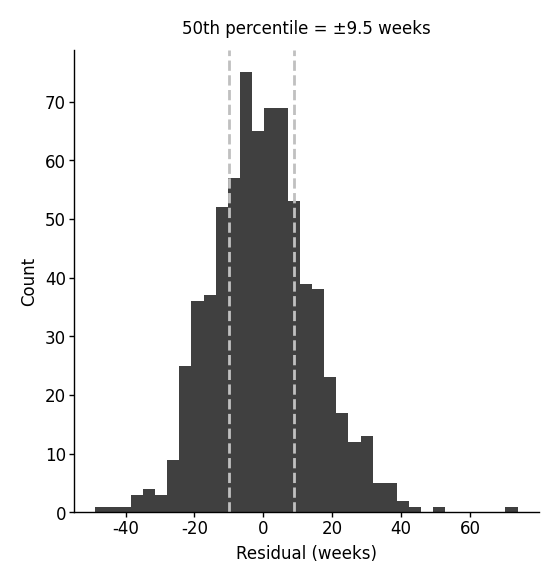

In [13]:
ax = sns.histplot(residuals['0'], element='step', color='k', linewidth=0, fill=True, bins=35)
ax.axvline(-10, color='silver', ls='--')
ax.axvline(9, color='silver', ls='--')
ax.set(xlabel="Residual (weeks)", title="50th percentile = ±9.5 weeks")
sns.despine()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

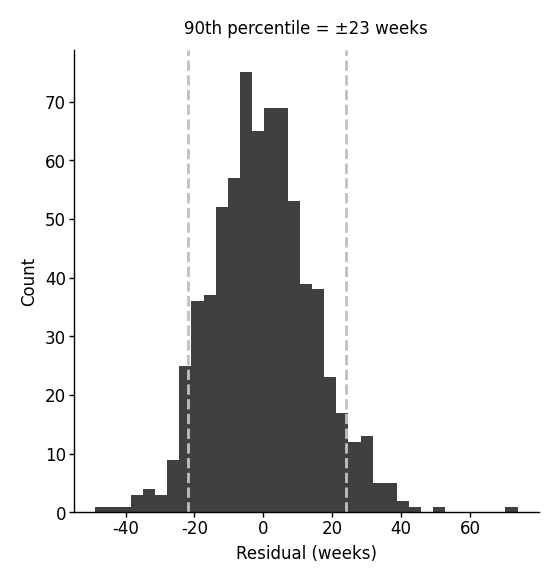

In [14]:
ax = sns.histplot(residuals['0'], element='step', color='k', linewidth=0, fill=True, bins=35)
ax.axvline(-22, color='silver', ls='--')
ax.axvline(24, color='silver', ls='--')
ax.set(xlabel="Residual (weeks)", title="90th percentile = ±23 weeks")
sns.despine()

In [28]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
    "mice": sex_id,
}

log_scale_sd = True

if log_scale_sd:
    age_sd = 0.15875
else:
    age_sd = 0.04

hypparams = {
    "log_age": True,
    "min_age": 3.999,
    "max_age": 127,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(sex_id),
    "lr": 0.25,
    "n_opt_iter": 500,
    "log_scale_sd": log_scale_sd,
}

## Fit model

In [29]:
mdl = fit_model(features, hypparams, 5, return_loss_on_error=True)

if len(mdl) == 1:
    print(hypparams['n_opt_iter'] - np.isnan(mdl['loss']).sum())

In [30]:
median_absolute_error(mdl['true_ages'][mdl['true_ages'] > 40], mdl['bio_ages'][mdl['true_ages'] > 40])

5.904728

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

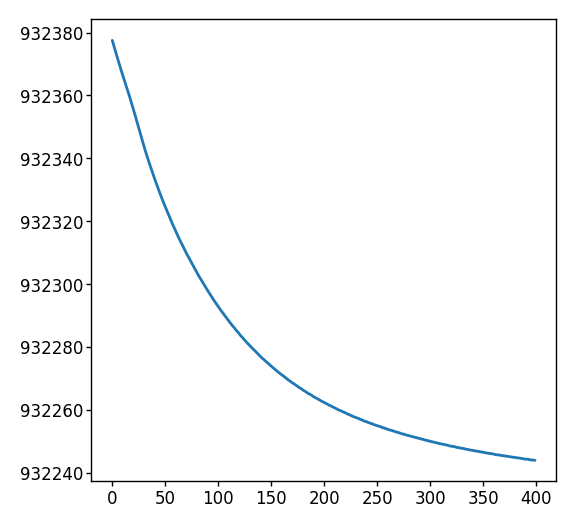

In [31]:
plt.plot(mdl['loss'][100:])

## Create extra dataframes for dana

In [32]:
def read_male_ontogeny2(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v02.parquet"
    )
    df = df[use_syllables]
    # IMPORTANT!!!
    #df = df.query('age <= 90')

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_mouse_area_df_v02.parquet'
    size_df = pd.read_parquet(pth)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]
    df = df[use_syllables]
    return df, sizes_col


def read_female_ontogeny2(use_syllables):
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v02.parquet"
    )
    df = df[use_syllables]
    #  IMPORTANT
    #df = df.query('age <= 90')

    # re-assign 52-wk old animals from their incorrect 8-wk old assignment
    x = ['d6f254af-d55a-427a-96e0-c452a233cbe2', '242bee8e-0ee7-45e7-8a13-678836a4cddb']

    idx = df.index.names
    tmp_df = df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    df = tmp_df.set_index(idx)

    pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_mouse_area_df_v02.parquet'
    size_df = pd.read_parquet(pth)

    idx = size_df.index.names
    tmp_df = size_df.reset_index()
    mask = tmp_df['uuid'].isin(x)
    tmp_df.loc[mask, 'age'] = 52
    size_df = tmp_df.set_index(idx)

    sizes_col = zscore(size_df.groupby('age')['quant_0.5'].transform(demean))
    sizes_col = sizes_col.loc[df.index]
    df = df.loc[sizes_col.index]

    return df, sizes_col


_df, sizes_col = read_male_ontogeny2(keep_syllables)
female_df, female_sizes_col = read_female_ontogeny2(keep_syllables)
df_copy = pd.concat([_df, female_df])

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(
    np.hstack([np.zeros(len(df_copy) - len(female_df)), np.ones(len(female_df))])[:, None]
).T

df_copy['sex'] = np.where(sex_id == 1)[0]
df_copy = df_copy.set_index('sex', append=True)
df_copy = df_copy.astype('float32')

df_copy['beh_age'] = mdl['bio_ages']

!mkdir -p /n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df

/n/groups/datta/win/home_folder/miniconda3/envs/aging-gpu/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
for s, _df in df_copy.groupby('sex'):
    _df = _df.copy()

    # new mapping technique - find the closest chron. age to map the biological age to
    unique_ages = _df.index.get_level_values('age').unique().values
    d = cdist(unique_ages[:, None], _df[['beh_age']], metric='cityblock')
    age_indices = np.argmin(d, axis=0)
    new_age_mapped = unique_ages[age_indices]

    _df = _df.droplevel(level=['age', 'sex']).drop(columns=['beh_age'])
    _df['age'] = new_age_mapped
    _df = _df.set_index('age', append=True)

    _levels = _df.index.names
    _levels = [_levels[-1]] + list(_levels[:-1])
    _df = _df.reorder_levels(_levels)

    if s == 0:
        # males
        _df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-09-13-ontogeny_males_raw_usage_df_beh_age.parquet')
    else:
        # females
        _df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-09-13-ontogeny_females_raw_usage_df_beh_age.parquet')

## Make ontogeny sex age plot

In [21]:
labels = LabelEncoder().fit_transform(np.hstack([np.zeros(len(df) - len(female_df)), np.ones(len(female_df))]))

age_df = pd.DataFrame(
    dict(bio_ages=mdl["bio_ages"], true_ages=mdl["true_ages"], labels=labels),
)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

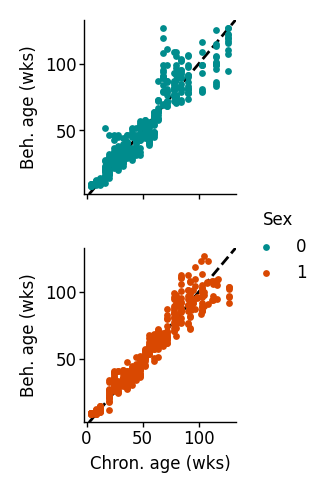

In [34]:
fgrid = sns.FacetGrid(data=age_df, row="labels", hue="labels", hue_order=[0, 1], palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], height=1.3, aspect=1)
fgrid.map(sns.scatterplot, "true_ages", "bio_ages", linewidths=0, s=6)
fgrid.set_titles("")
for a in fgrid.axes.flat:
    add_identity(a, ls='--', color='k', zorder=-1)
fgrid.set_xlabels("Chron. age (wks)")
fgrid.set_ylabels("Beh. age (wks)")
fgrid.add_legend(title="Sex")
# saver(fgrid.fig, "ontogeny-sex-chron-vs-beh-age-all-timepoints");

In [23]:
def make_plot(age_df, width, height):
    boundaries = np.arange(age_df["labels"].max() + 2) - 0.5
    pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)
    fig = figure(width, height)
    ax = fig.gca()

    perm = np.random.permutation(len(age_df))
    im = ax.scatter(
        age_df["true_ages"].iloc[perm],
        age_df["bio_ages"].iloc[perm],
        c=age_df["labels"].iloc[perm],
        cmap=pal,
        vmin=0,
        vmax=1,
        s=1,
    )
    cb = fig.colorbar(
        mappable=im,
        boundaries=boundaries,
        ax=ax,
        label="Sex",
    )
    cb.set_ticks(range(0, 2))
    cb.set_ticklabels(["Male", "Female"])
    add_identity(ax, c="k", ls="--", zorder=-2)
    ax.set(
        xlabel="Chronological age (wks)",
        ylabel="Behavioral age (wks)",
        aspect="equal",
        xlim=(0, 120),
    )
    sns.despine()
    return fig

# Plots and analysis

## Predicted syllables plot

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

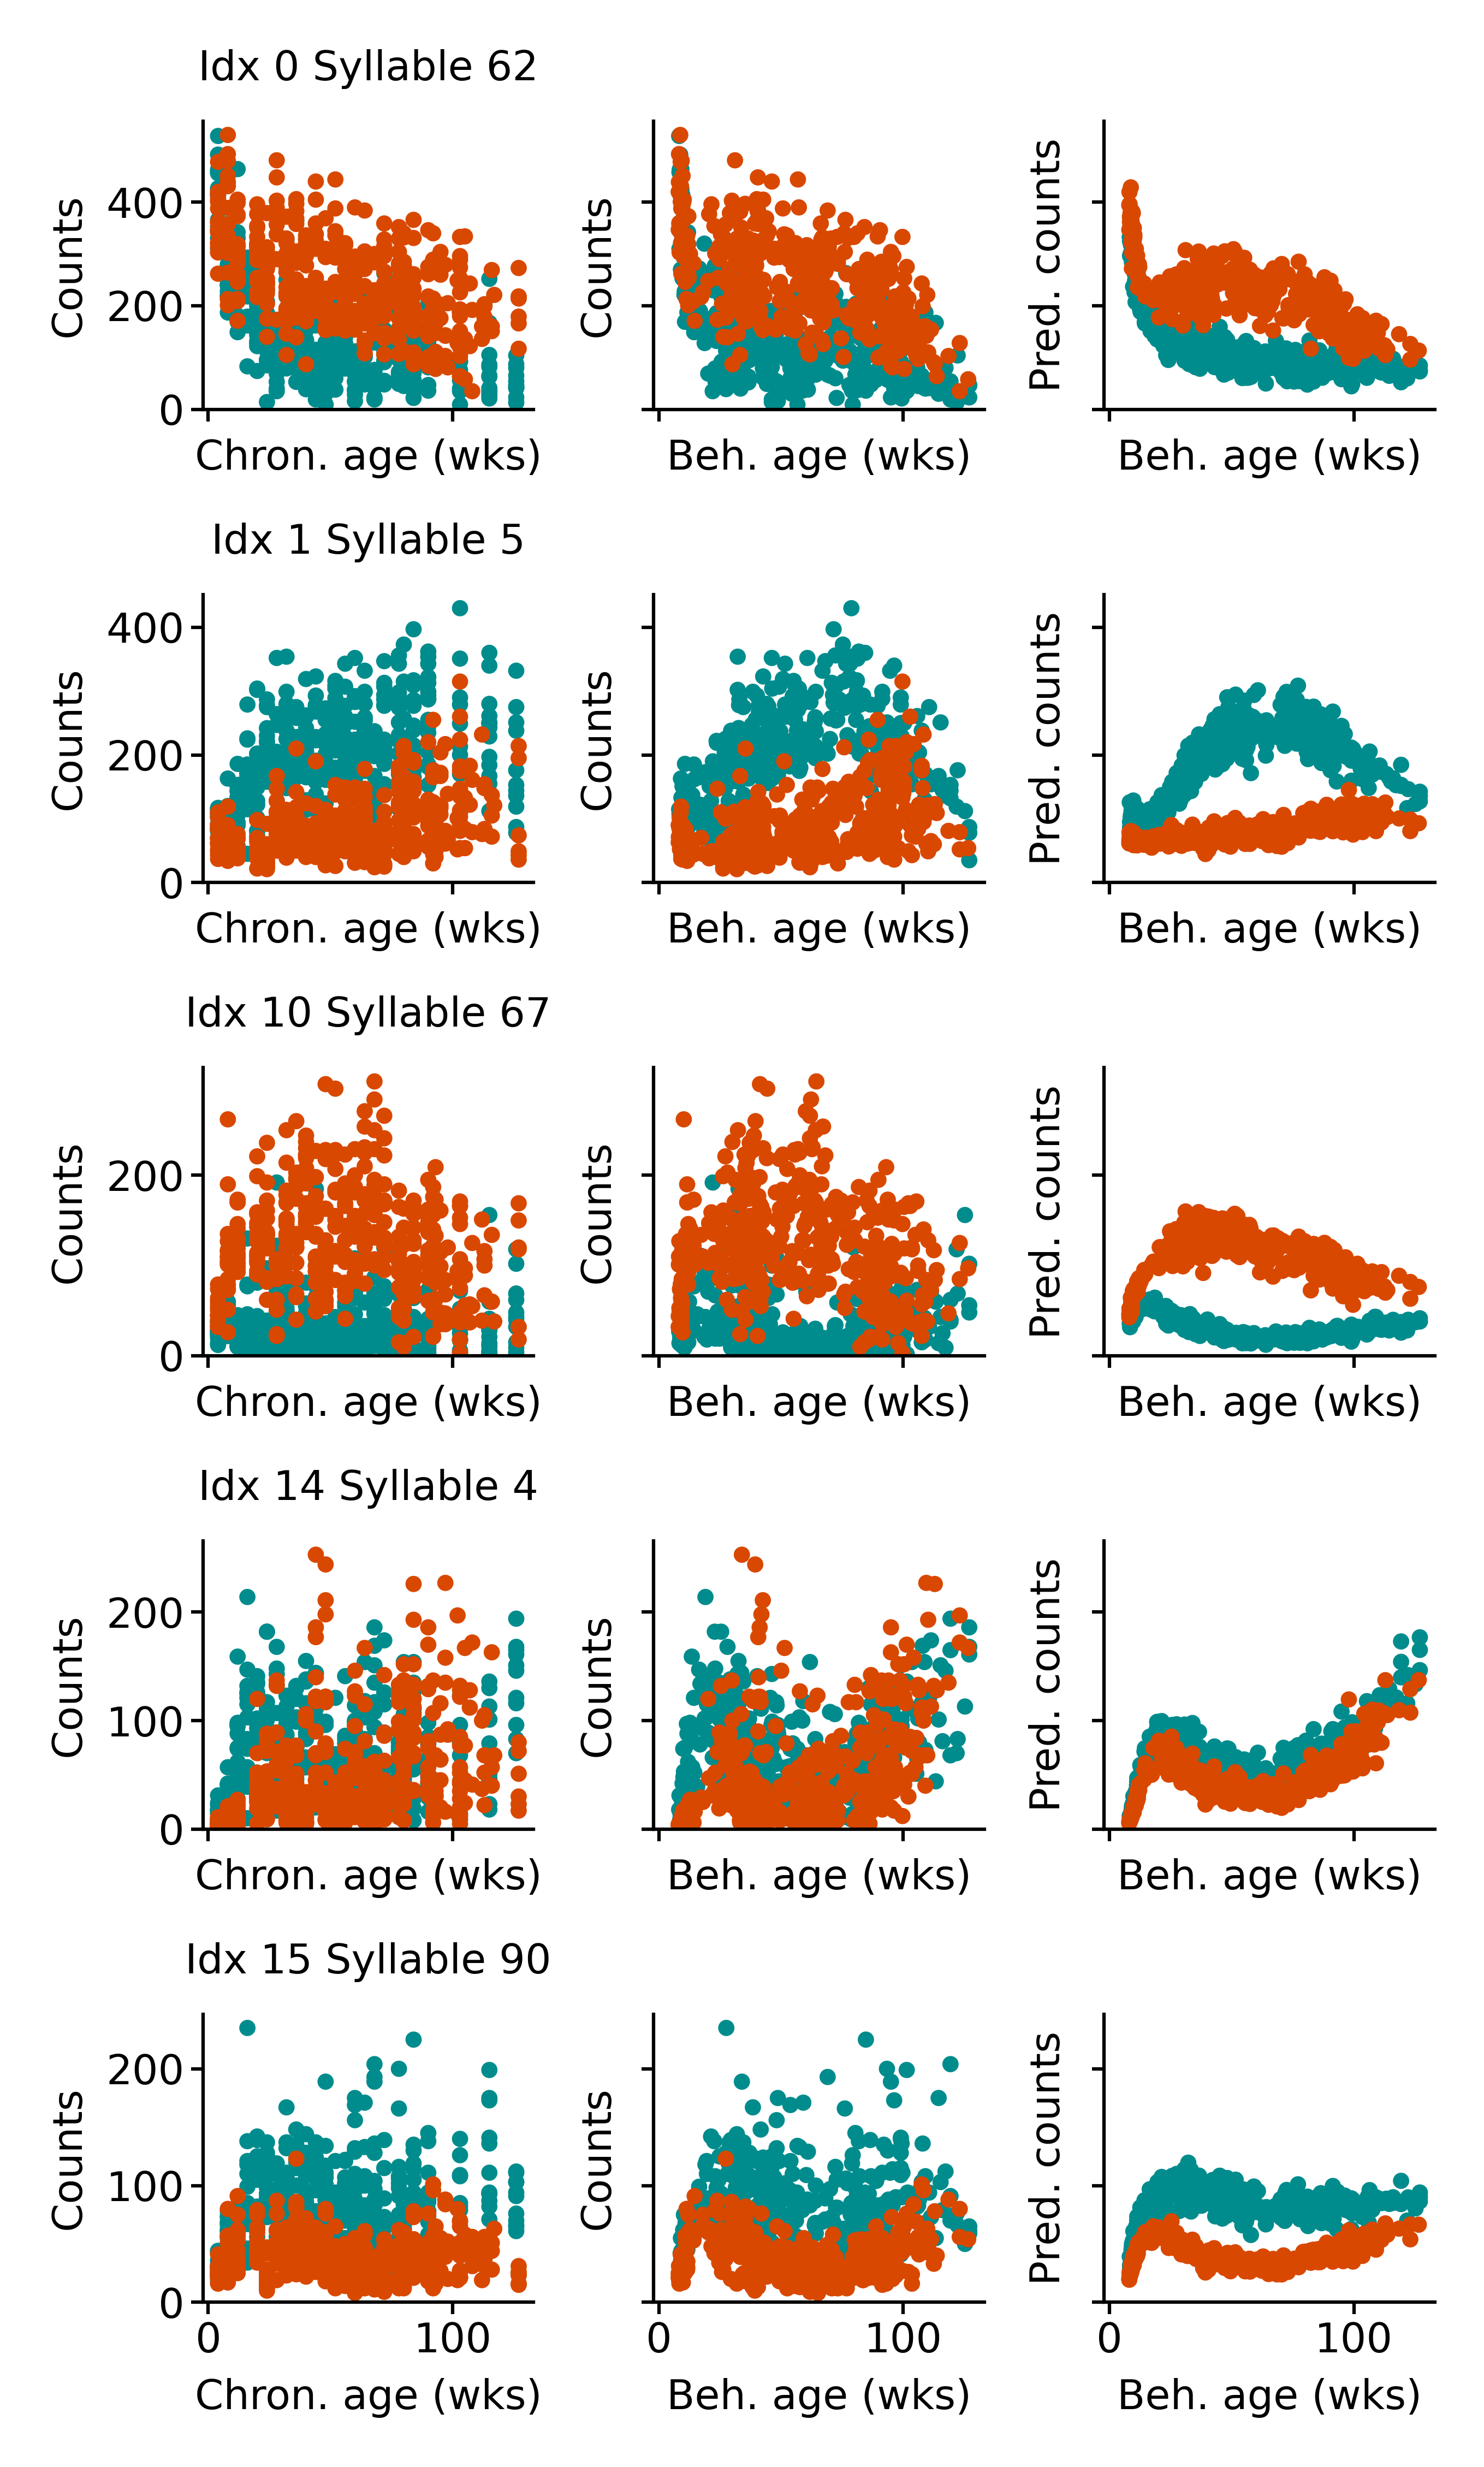

In [24]:
# male is blue, female is orange
example_mice = [0, 1]

mask = []
for m in example_mice:
    mask.append(labels == m)
mask = reduce(or_, mask)

sylls = [0, 1, 10, 14, 15]
fig, ax = plt.subplots(len(sylls), 3, figsize=(3, len(sylls)), sharex=True, dpi=900)

true_age = mdl["true_ages"][mask]
bio_age = mdl["bio_ages"][mask]
counts = mdl["counts"][mask]
pred_counts = mdl["predicted_counts"][mask]

pal = sns.blend_palette([COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)], as_cmap=True)

for a, syll, i in zip(ax, map(lambda i: int(sort_idx[i]), sylls), sylls):
    max_counts = max([counts[:, syll].max(), pred_counts[:, syll].max()]) * 1.05
    a[0].scatter(true_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[0].set(title=f"Idx {i} Syllable {df.columns[syll]}", ylabel="Counts", xlabel="Chron. age (wks)", ylim=(0, max_counts))

    a[2].scatter(bio_age, pred_counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[2].set(ylabel="Pred. counts", xlabel="Beh. age (wks)", ylim=(0, max_counts), yticklabels=[])

    a[1].scatter(bio_age, counts[:, syll], s=2.5, c=labels[mask], cmap=pal, vmax=1, vmin=0, rasterized=True)
    a[1].set(ylabel="Counts", xlabel="Beh. age (wks)", ylim=(0, max_counts), yticklabels=[])

sns.despine()
fig.tight_layout()

# saver(fig, "sex-ontogeny-true-vs-predicted-counts", dpi=300);

In [25]:
list(mdl['params'])

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

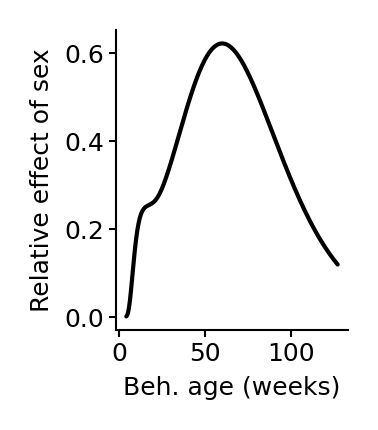

In [33]:
comps = mdl['init_components']

x = mdl['params']['development_weights']
dev = np.exp(x @ comps.bases['development']).squeeze()
_ages = comps.age_unnormalizer(comps.age_samples)
dev = np.where(_ages < 4, np.nan, dev)

fig = figure(1, 1.3)
ax = fig.gca()
ax.plot(_ages, dev, color='k')
#plt.xlim(0, 100)
# plt.ylim(0, None)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
# saver(fig, "ontogeny-effect-of-sex");

### At each chronological age, what is the male/female distribution of biological age?

In [35]:
age_df['bin'] = pd.cut(age_df['true_ages'], 8, labels=False)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

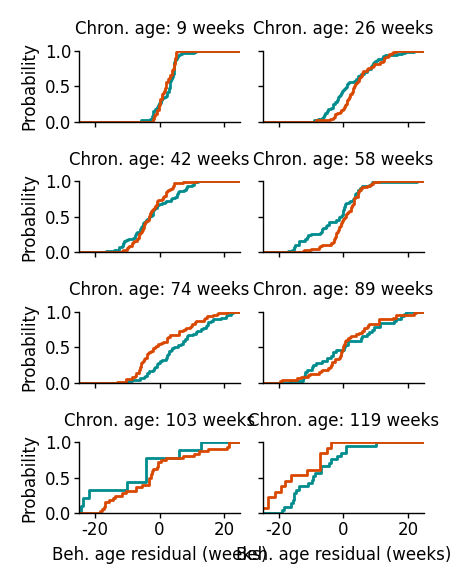

In [36]:
fig, ax = plt.subplots(4, 2, figsize=(2.2, 2.9), sharey=True, sharex=True)
for a, (_bin, _df) in zip(ax.flat, age_df.groupby("bin")):
    mean_age = _df["true_ages"].mean()
    _male_df = _df.query("labels == 0")
    _female_df = _df.query("labels == 1")
    sns.histplot(
        data=_male_df["bio_ages"] - _male_df['true_ages'],
        ax=a,
        color=COLORMAPS.ont_male(255),
        bins=np.linspace(-25, 25, 200),
        fill=False,
        cumulative=True,
        element="step",
        stat='probability',
    )
    sns.histplot(
        data=_female_df["bio_ages"] - _female_df['true_ages'],
        ax=a,
        color=COLORMAPS.ont_female(255),
        bins=np.linspace(-25, 25, 200),
        fill=False,
        cumulative=True,
        element="step",
        stat='probability',
    )
    a.set(title=f"Chron. age: {mean_age:0.0f} weeks", ylim=(0, 1))
for a in ax[-1]:
    a.set(xlabel="Beh. age residual (weeks)", xlim=(-25, 25))
sns.despine()
fig.tight_layout()
# saver(fig, "male-female-difference-to-avg-chron-age");

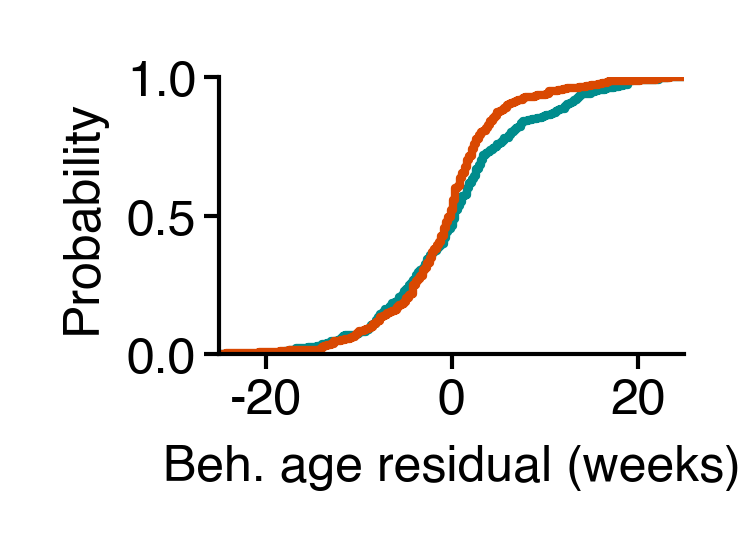

In [31]:
fig = figure(1, 0.6)
_male_df = age_df.query("labels == 0")
_female_df = age_df.query("labels == 1")
sns.histplot(
    data=_male_df["bio_ages"] - _male_df['true_ages'],
    color=COLORMAPS.ont_male(255),
    bins=np.linspace(-25, 25, 200),
    fill=False,
    cumulative=True,
    element="step",
    stat='probability',
)
a = sns.histplot(
    data=_female_df["bio_ages"] - _female_df['true_ages'],
    color=COLORMAPS.ont_female(255),
    bins=np.linspace(-25, 25, 200),
    fill=False,
    cumulative=True,
    element="step",
    stat='probability',
)
a.set(xlabel="Beh. age residual (weeks)", xlim=(-25, 25), ylim=(0, 1))
sns.despine()
# saver(fig, "male-female-difference-to-avg-chron-age-combined");

In [32]:
ks_result = ks_2samp(_male_df['bio_ages'] - _male_df['true_ages'], _female_df['bio_ages'] - _female_df['true_ages'])
ks_result

KstestResult(statistic=0.1301332878619945, pvalue=0.007193905735751196, statistic_location=6.0220947, statistic_sign=-1)

## Sorting by model predictions

In [38]:
df_copy = df.copy().astype('float32')

# normalize to sum to 1
df_copy = df_copy / (df_copy.sum(1).to_numpy()[:, None])
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)
df_copy['age_bin'] = pd.cut(df_copy.index.get_level_values('age'), 24, labels=False)
df_copy['beh_age_bin'] = pd.cut(df_copy.index.get_level_values('beh_age'), 24, labels=False)
df_copy = df_copy.set_index(['beh_age_bin', 'age_bin'], append=True)

In [39]:
#df_copy.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-09-13-ont_beh_age_df_both_sexes.parquet')

### Pre-bambi males and females

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

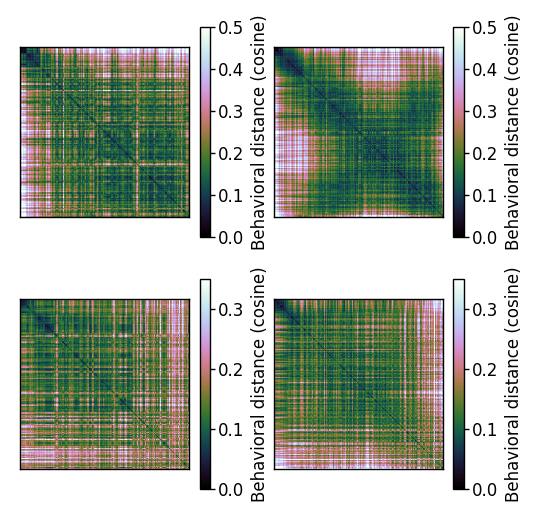

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(3, 3))

sex_vmap = {
    0: 0.5,
    1: 0.35,
}

for (_sex, _sorting), a in zip(product([0, 1], ["age", "beh_age"]), ax.flat):
    d = pdist(df_copy.query('sex == @_sex').sort_index(level=_sorting), metric="cosine")
    d = squareform(d)

    im = a.imshow(d, cmap="cubehelix", vmax=sex_vmap[_sex], vmin=0)
    fig.colorbar(im, ax=a, label="Behavioral distance (cosine)")
    a.set(xticks=[], yticks=[])
#saver(fig, 'male-female-distance-matrix-pre-post-bambi-sorting-cosine');

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

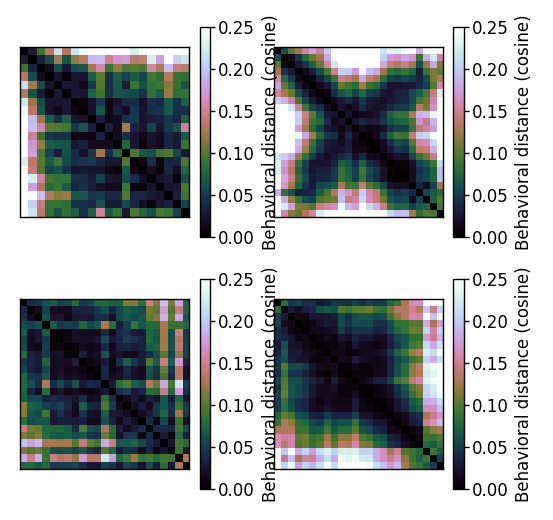

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(3, 3))

sex_vmap = {
    0: 0.25,
    1: 0.25,
}

for (_sex, _sorting), a in zip(product([0, 1], ["age_bin", "beh_age_bin"]), ax.flat):
    d = pdist(df_copy.query('sex == @_sex').groupby(_sorting).mean(), metric="cosine")
    d = squareform(d)

    im = a.imshow(d, cmap="cubehelix", vmax=sex_vmap[_sex], vmin=0)
    fig.colorbar(im, ax=a, label="Behavioral distance (cosine)")
    a.set(xticks=[], yticks=[])
#saver(fig, 'ontogeny-averaged-distance-matrix-pre-post-bambi-sorting-cosine');

## PCA on model predictions

In [42]:
pc = mdl['predicted_counts']
pc = pc / pc.sum(1, keepdims=True)

In [43]:
pca = PCA(n_components=2)
scores = pca.fit_transform(pc)
scores_df = pd.DataFrame(scores, index=df.index)
scores_df['bio_age'] = mdl['bio_ages']

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

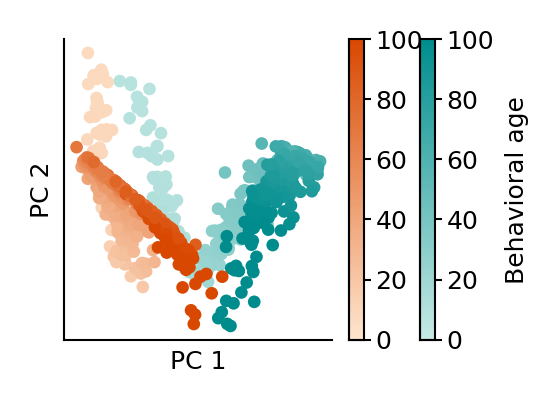

In [44]:
fig = figure(1.8, 1.3)
ax = fig.gca()
for sex, _df in scores_df.groupby('sex'):
    cm = COLORMAPS.ont_male if sex == 0 else COLORMAPS.ont_female
    im = ax.scatter(_df[0], _df[1], c=_df['bio_age'], cmap=cm, s=5, vmin=0, vmax=100)
    cb = fig.colorbar(im, ax=ax, label="Behavioral age" if sex == 0 else None)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
#saver(fig, "model-based-pca-males-females-bio-age");

## Plot age likelihoods

In [40]:
_age = mdl['init_components'].age_unnormalizer(mdl['init_components'].age_samples)

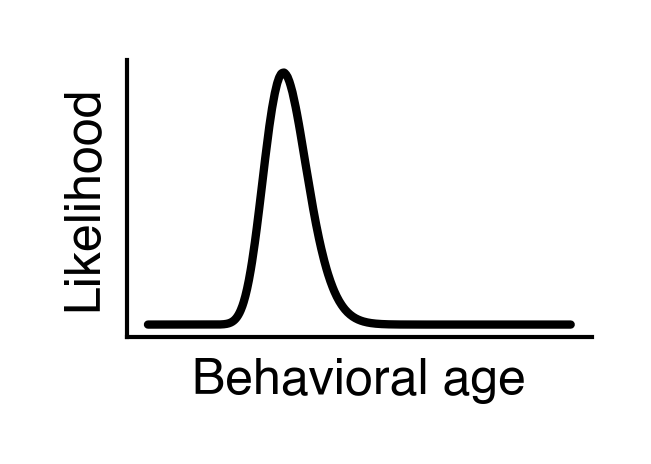

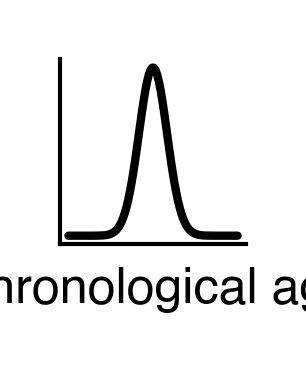

In [41]:
# bambi likelihood
fig = figure(1, 0.6)
ax = fig.gca()
ax.plot(_age, mdl['age_likelihoods'][100], color='k')
ax.set(xticks=[], yticks=[], xlabel="Behavioral age", ylabel="Likelihood")
sns.despine()
saver(fig, "beh-age-likelihood-function-schematic");

# gaussian likelihood
out = norm.pdf(np.linspace(-6, 6, 100), loc=0, scale=1)

fig = figure(0.4, 0.4)
ax = fig.gca()
ax.plot(out, color='k')
ax.set(xticks=[], yticks=[], xlabel="Chronological age")
sns.despine()
#saver(fig, "chron-age-prior-schematic");

## Relative contributions

In [42]:
mdl_params = mdl['params']
mdl_components = mdl['init_components']
bias_scale = np.exp(mdl_params['development_weights'] @ mdl_components.bases['development'])
list(mdl_params)

['bio_basis_weights', 'development_weights', 'individual_biases', 'size_slope']

### Size

In [43]:
size_effect = np.abs(mdl_params['size_slope'].squeeze())

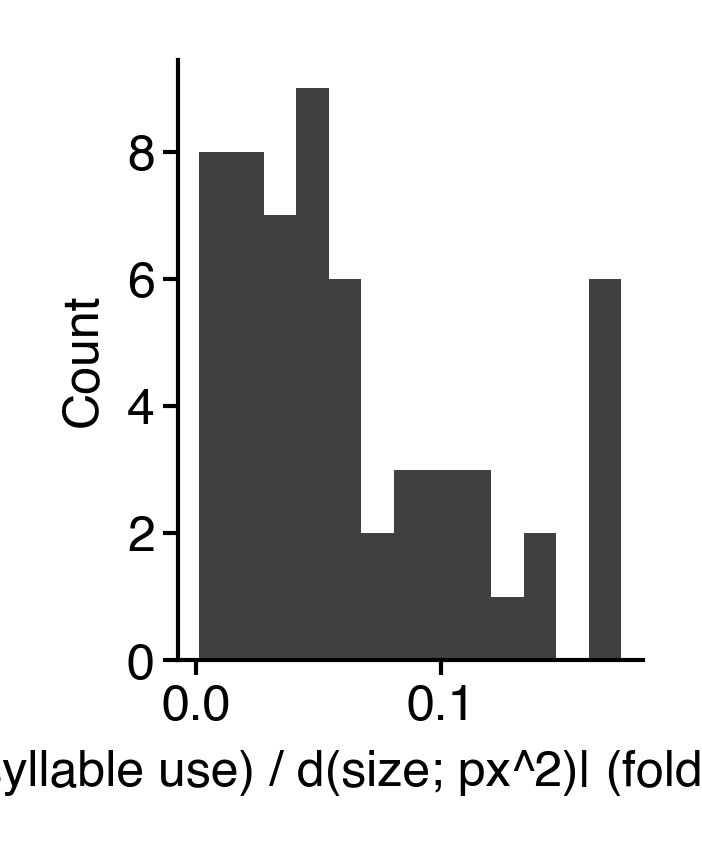

In [44]:
# size plot - histogram of slopes across syllables
fig = figure(1, 1.3)

ax = sns.histplot(size_effect, bins=13, element='step', fill=True, linewidth=0, color="k")
ax.set(xlabel="|d(syllable use) / d(size; px^2)| (fold-change)")
sns.despine()
#saver(fig, "size-deriv-histogram");

### Age

In [45]:
def get_component_diffs(comp, age1, age2):
    x = np.interp(mdl_components.age_normalizer(np.array([age1, age2])), mdl_components.age_samples, comp)
    return x[1] - x[0], age2 - age1

def get_spline_diffs(splines, age1, age2, syllable):
    '''returns the difference in spline values and the difference in ages'''
    return get_component_diffs(splines[syllable], age1, age2)

In [46]:
splines = mdl_params['bio_basis_weights'] @ mdl_components.bases['bio']

bio_deriv = np.diff(splines, axis=1)

true_age = mdl_components.age_unnormalizer(mdl_components.age_samples)
age_diff = np.diff(true_age)

bio_deriv_norm = bio_deriv / age_diff[None]

In [47]:
def get_bio_deriv(age, syllable):
    '''age can be a vector or scalar.
    Syllable should be an int from 0-58'''
    return np.interp(age, true_age[:-1], bio_deriv_norm[syllable])

In [48]:
deriv_df = pd.DataFrame(bio_deriv_norm.T, columns=pd.Index(df.columns, name="syllable"), index=pd.Index(true_age[:-1], name="age")).abs()
melt_deriv_df = deriv_df.reset_index().melt(id_vars='age').query('age < 100 & age > 4')

In [49]:
melt_deriv_df

age syllable     value
168     4.009035        0  0.046490
169     4.025664        0  0.046469
170     4.042362        0  0.046440
171     4.059130        0  0.046417
172     4.075966        0  0.046386
...          ...      ...       ...
57884  98.320641       98  0.010223
57885  98.728470       98  0.010239
57886  99.137993       98  0.010256
57887  99.549179       98  0.010272
57888  99.962105       98  0.010288

[45124 rows x 3 columns]

/tmp/ipykernel_17050/4294504105.py:2: UserWarning: 
The palette list has fewer values (1) than needed (58) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


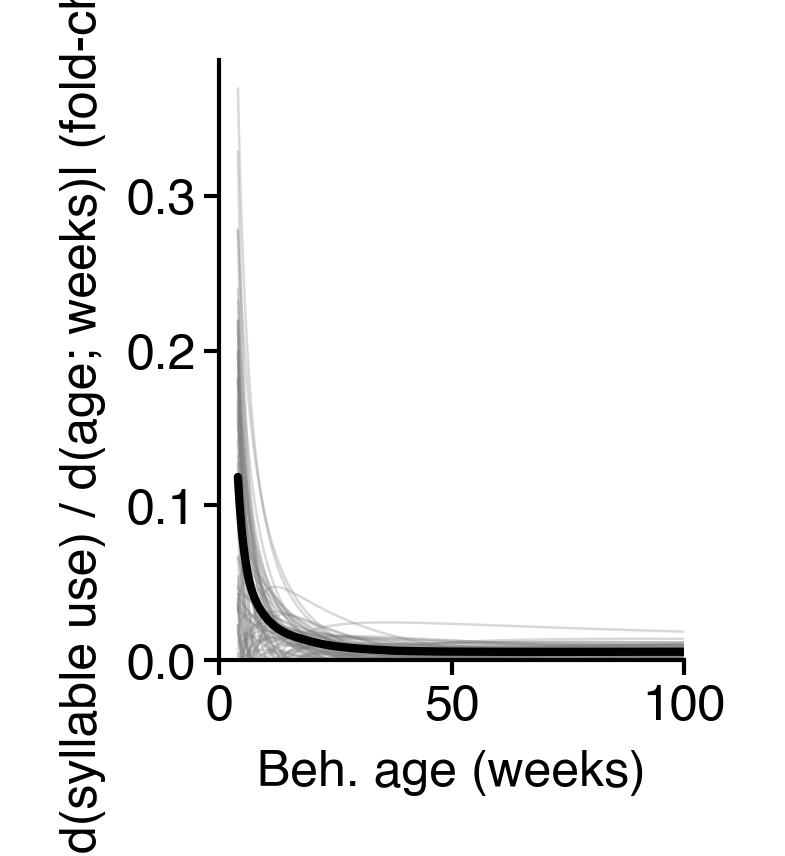

In [50]:
fig = figure(1, 1.3)
ax = sns.lineplot(
    data=melt_deriv_df,
    x="age",
    y="value",
    hue="syllable",
    errorbar=None,
    err_kws=dict(lw=0),
    palette=["gray"],
    legend=False,
    linewidth=0.3,
    alpha=0.3,
)
ax = sns.lineplot(
    data=melt_deriv_df,
    x="age",
    y="value",
    errorbar=None,
    err_kws=dict(lw=0),
    color='k',
    legend=False,
    linewidth=1,
    alpha=1,
    ax=ax
)
ax.set(
    xlabel="Beh. age (weeks)",
    ylabel="|d(syllable use) / d(age; weeks)| (fold-change)",
    xlim=(0, 100),
    ylim=(0, None),
)
sns.despine()
#saver(fig, "age-deriv-lineplot");

### Sex

In [51]:
sex_bias = np.array(raise_dim(mdl_params['individual_biases'], axis=1))
sex_bias_effect = np.mean(np.abs(sex_bias), axis=1).squeeze()
sex_bias_effect_w_scaling = (bias_scale * sex_bias_effect[:, None])

In [52]:
sex_deriv_df = pd.DataFrame(sex_bias_effect_w_scaling.T, columns=pd.Index(df.columns, name="syllable"), index=pd.Index(true_age, name="age")).abs()
melt_sex_deriv_df = sex_deriv_df.reset_index().melt(id_vars='age').query('age < 100 & age > 4')

/tmp/ipykernel_17050/3067790183.py:2: UserWarning: 
The palette list has fewer values (1) than needed (58) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


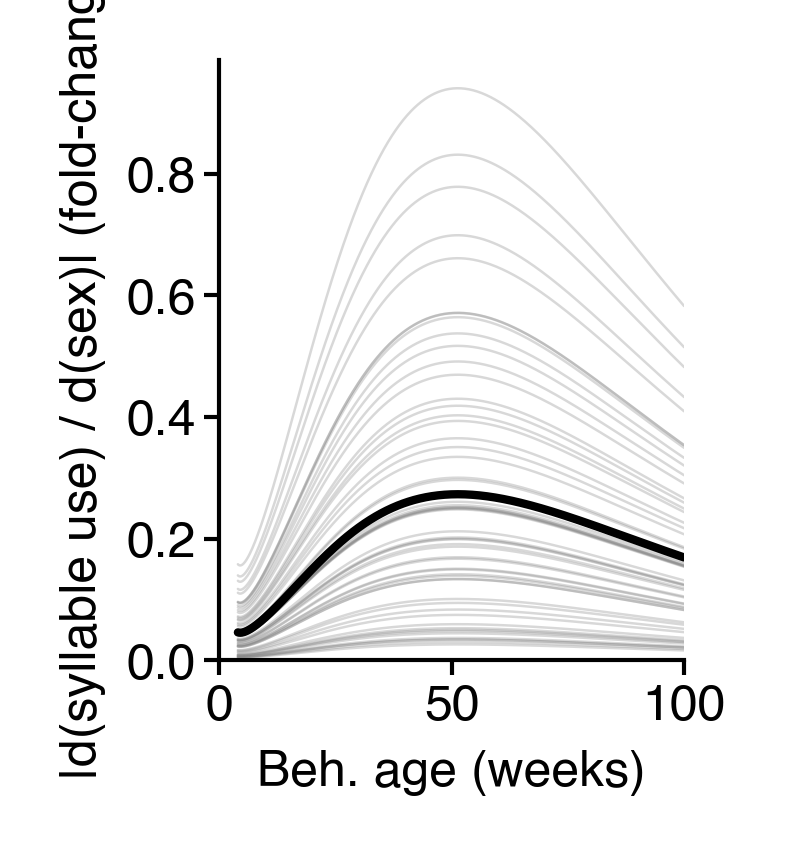

In [53]:
fig = figure(1, 1.3)
ax = sns.lineplot(
    data=melt_sex_deriv_df,
    x="age",
    y="value",
    hue="syllable",
    errorbar=None,
    err_kws=dict(lw=0),
    palette=["gray"],
    legend=False,
    linewidth=0.3,
    alpha=0.3,
)
ax = sns.lineplot(
    data=melt_sex_deriv_df,
    x="age",
    y="value",
    errorbar=None,
    err_kws=dict(lw=0),
    color='k',
    legend=False,
    linewidth=1,
    alpha=1,
    ax=ax,
)
ax.set(
    xlabel="Beh. age (weeks)",
    ylabel="|d(syllable use) / d(sex)| (fold-change)",
    xlim=(0, 100),
    ylim=(0, None),
)
sns.despine()
#saver(fig, "sex-deriv-lineplot");

### Rank-order each syllable + effect

In [54]:
sex_rank = np.argsort(np.argsort(sex_deriv_df.mean().values))
size_rank = np.argsort(np.argsort(size_effect))
age_rank = np.argsort(np.argsort(deriv_df.mean().values))

In [55]:
rank_df = pd.DataFrame(dict(sex=sex_rank, size=size_rank, age=age_rank), index=pd.Index(range(len(sex_rank)), name="syll_idx"))

In [56]:
melt_rank_df = rank_df.reset_index().melt(id_vars='syll_idx')

In [57]:
melt_rank_df

syll_idx variable  value
0           0      sex     17
1           1      sex     30
2           2      sex     37
3           3      sex     52
4           4      sex     13
..        ...      ...    ...
169        53      age     17
170        54      age      8
171        55      age      0
172        56      age     50
173        57      age     22

[174 rows x 3 columns]

In [58]:
age_rank_map = rank_df['age']

In [59]:
melt_rank_df['age_rank_map'] = melt_rank_df['syll_idx'].map(age_rank_map)

/tmp/ipykernel_17050/1766685904.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel="Syllable rank", xlabel="Factor", xticklabels=["Age", "Sex", "Size"])


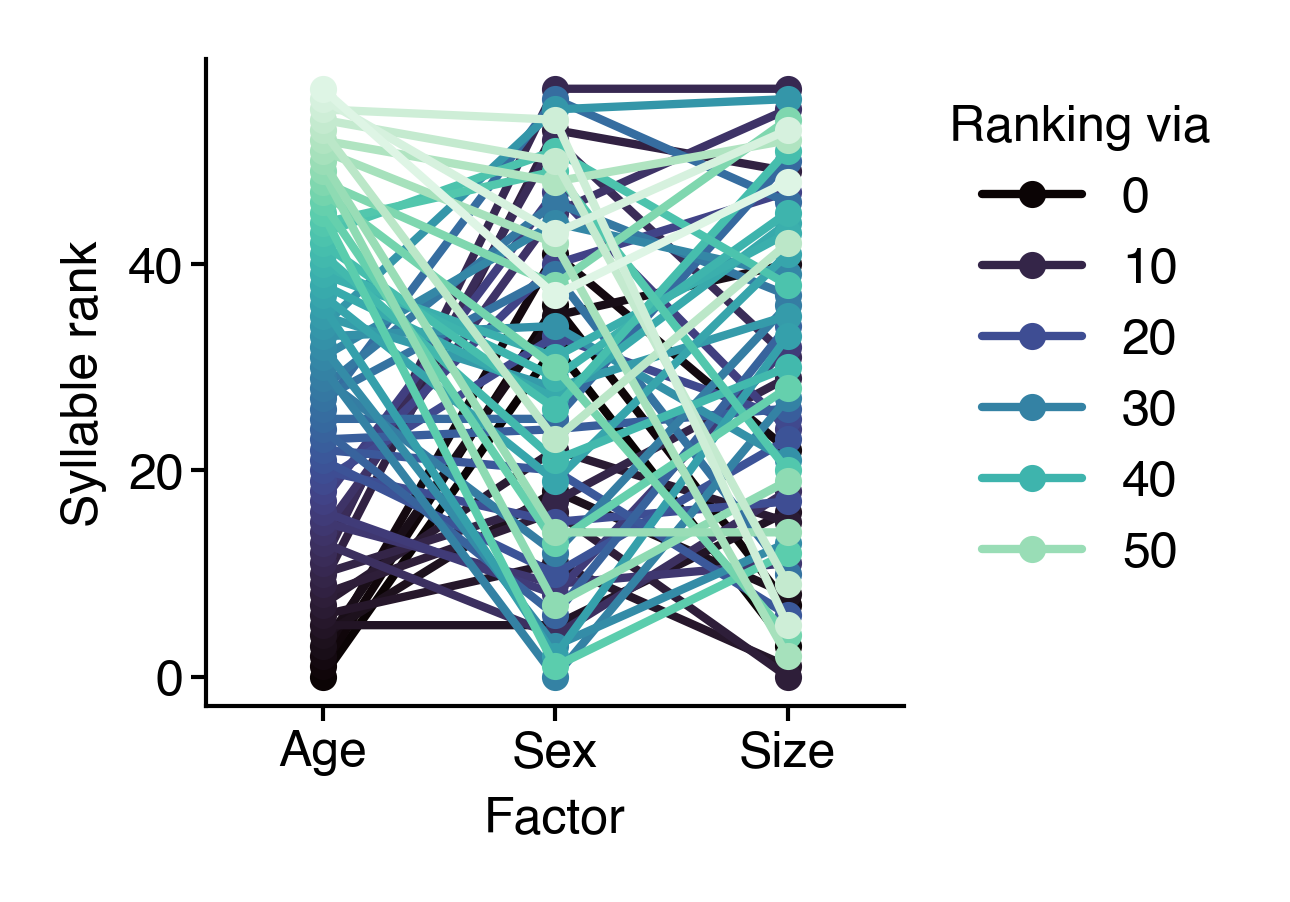

In [60]:
fig = figure(1.5, 1.4)
ax = sns.pointplot(data=melt_rank_df, x='variable', y='value', hue='age_rank_map', order=['age', 'sex', 'size'], palette='mako', linewidth=1)
ax.set(ylabel="Syllable rank", xlabel="Factor", xticklabels=["Age", "Sex", "Size"])
legend(ax, title="Ranking via")
sns.despine()
#saver(fig, "bambi-factor-syllable-derivative-ranking");

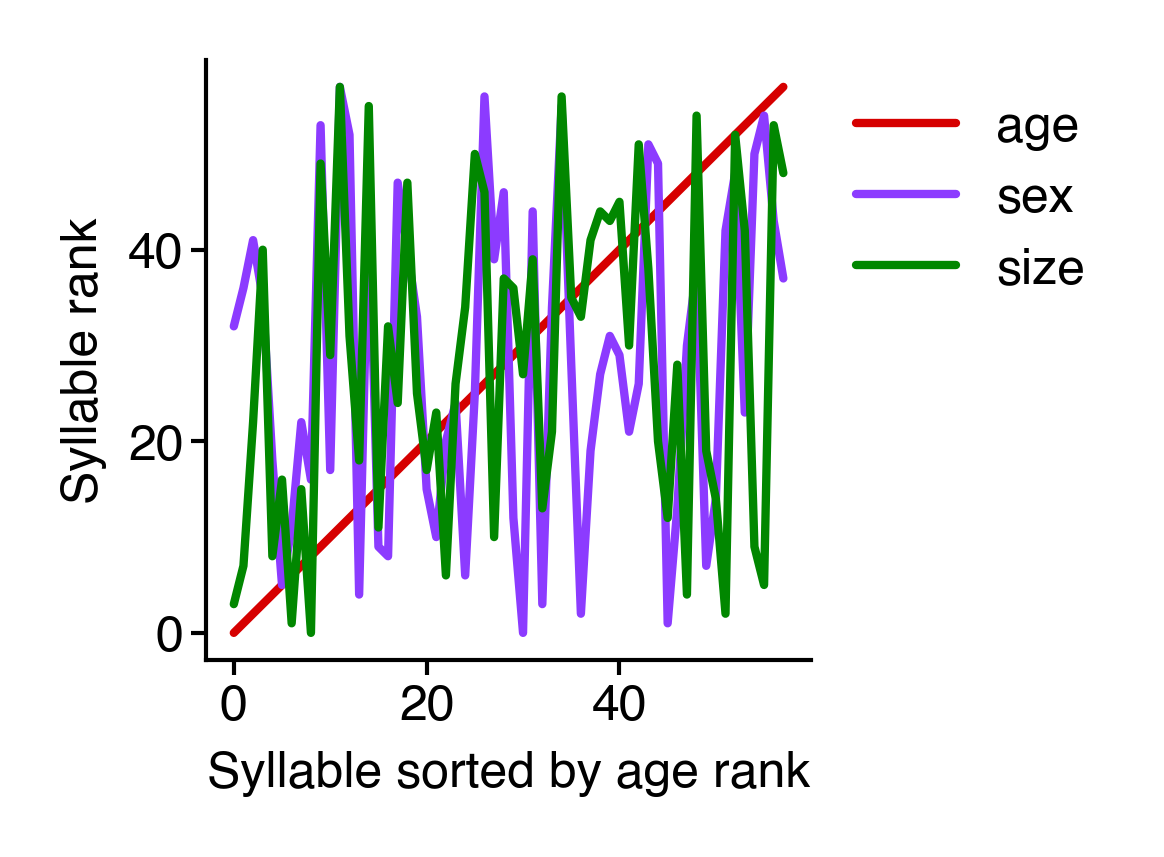

In [61]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=melt_rank_df,
    x="age_rank_map",
    y="value",
    hue="variable",
    hue_order=["age", "sex", "size"],
    palette=cc.glasbey[:3],
    linewidth=1,
)
ax.set(ylabel="Syllable rank", xlabel="Syllable sorted by age rank")
legend(ax)
sns.despine()
#saver(fig, "sorted-factor-rankings");

## Relative contributions

In [45]:
conc_c = mdl['concentration_components']

In [46]:
spline_weights = mdl['params']['bio_basis_weights']

In [47]:
spline_weights.shape

(58, 4)

In [48]:
spline_avgs = spline_weights.mean(1)

In [49]:
bio_comp = conc_c['bio'].copy()
bio_comp = bio_comp - spline_avgs[:, None]

In [50]:
indiv_components = conc_c['indiv'] * conc_c['indiv_scale'][None, :, None]

In [51]:
total = (
    np.abs(bio_comp[..., None])
    + np.abs(indiv_components)
    + np.abs(conc_c["size"][:, None, :])
)


In [52]:
inds = np.argmax(mdl['age_likelihoods'], axis=1)

In [53]:
bio = np.abs(bio_comp[..., None]) / total
indiv = np.abs(indiv_components) / total
size = np.abs(conc_c['size'][:, None, :]) / total

In [54]:
inds = np.argmax(mdl['age_likelihoods'], axis=1)

In [55]:
bio = bio[:, inds, np.arange(len(inds))]
indiv = indiv[:, inds, np.arange(len(inds))]
size = size[:, inds, np.arange(len(inds))]

In [56]:
bio_df = pd.DataFrame(bio.T, index=df.index).reset_index()
bio_df["bio_age"] = mdl["bio_ages"]
bio_df = bio_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
bio_df["type"] = "Beh. age"

size_df = pd.DataFrame(size.T, index=df.index).reset_index()
size_df["bio_age"] = mdl["bio_ages"]
size_df = size_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
size_df["type"] = "Size"

indiv_df = pd.DataFrame(indiv.T, index=df.index).reset_index()
indiv_df["bio_age"] = mdl["bio_ages"]
indiv_df = indiv_df.drop(columns=['subject_name', 'session_name', 'uuid', 'date']).melt(
    id_vars=["mouse", "age", "bio_age", "sex"], var_name="syllable", value_name="influence"
)
indiv_df["type"] = "Sex"

In [57]:
plt_dfs = pd.concat([bio_df, size_df, indiv_df])
plt_dfs['bio_bin'] = pd.cut(plt_dfs['bio_age'], 25)
plt_dfs['bio_bin'] = plt_dfs['bio_bin'].map(lambda x: x.mid)
plt_dfs['age_bin'] = pd.cut(plt_dfs['age'], 25)
plt_dfs['age_bin'] = plt_dfs['age_bin'].map(lambda x: x.mid)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

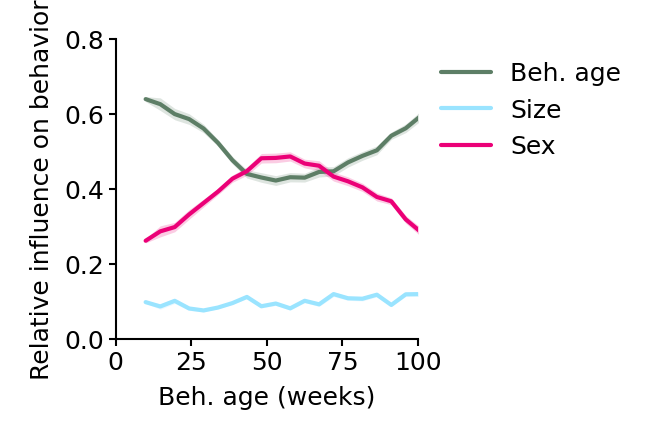

In [58]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=plt_dfs,
    x="bio_bin",
    y="influence",
    errorbar=("se", 2),
    hue="type",
    palette=cc.glasbey[24:27],
    err_kws=dict(lw=0),
)
ax.set(
    xlabel="Beh. age (weeks)",
    ylabel="Relative influence on behavior",
    ylim=(0, 0.8),
    xlim=(0, 100),
)
legend()
sns.despine()
#saver(fig, "sex-component-influence-on-behavior");

In [59]:
plt_dfs.head()

mouse  age   bio_age  sex syllable  influence      type bio_bin age_bin
0  4M_01_01    4  9.020694    0        0   0.826700  Beh. age  9.8895  6.3985
1  4M_01_02    4  8.593954    0        0   0.869385  Beh. age  9.8895  6.3985
2  4M_01_03    4  7.908835    0        0   0.872435  Beh. age  9.8895  6.3985
3  4M_01_04    4  7.963779    0        0   0.863828  Beh. age  9.8895  6.3985
4  4M_02_01    4  8.130914    0        0   0.902939  Beh. age  9.8895  6.3985

/tmp/ipykernel_41401/2419310794.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data=plt_dfs.groupby(['mouse', 'age', 'bio_bin', 'type'])['influence'].mean().reset_index(),
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families

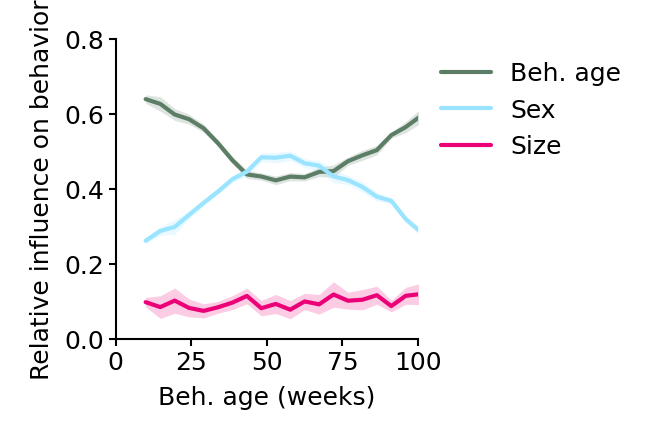

In [60]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=plt_dfs.groupby(['mouse', 'age', 'bio_bin', 'type'])['influence'].mean().reset_index(),
    x="bio_bin",
    y="influence",
    errorbar=("se", 2),
    hue="type",
    palette=cc.glasbey[24:27],
    err_kws=dict(lw=0),
)
ax.set(
    xlabel="Beh. age (weeks)",
    ylabel="Relative influence on behavior",
    ylim=(0, 0.8),
    xlim=(0, 100),
)
legend()
sns.despine()
#saver(fig, "sex-component-influence-on-behavior-v2");

In [72]:
x = pd.pivot_table(
    plt_dfs.groupby(["syllable", "type"])["influence"].mean().reset_index(),
    index="syllable",
    columns="type",
    values="influence",
)
remapping = dict(
    map(reversed, enumerate(x.sort_values(by="Beh. age", ascending=False).index))
)

In [73]:
plt_dfs['sorted_syllable'] = plt_dfs['syllable'].map(remapping)

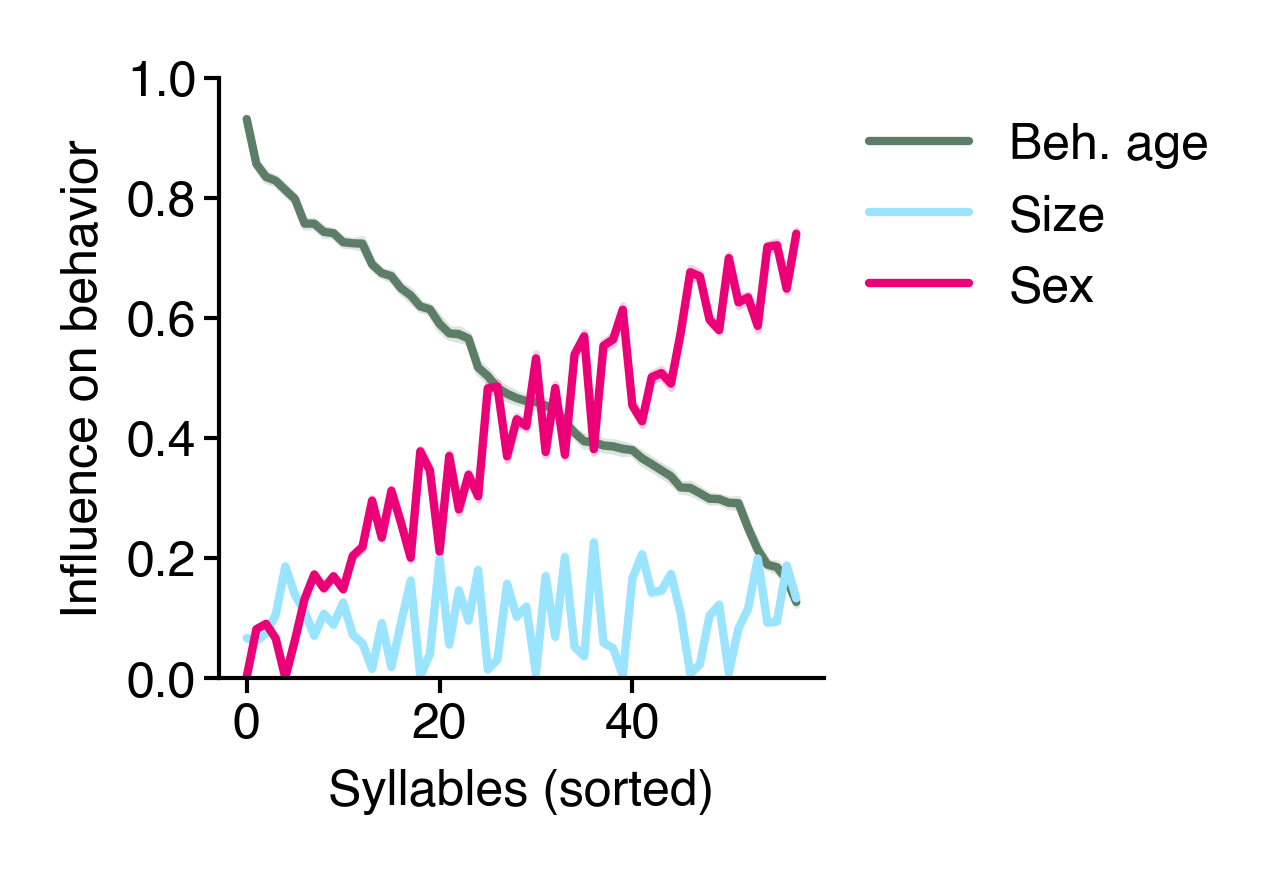

In [74]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(data=plt_dfs, x='sorted_syllable', y='influence', errorbar='se', hue='type', palette=cc.glasbey[24:27])
ax.set(xlabel="Syllables (sorted)", ylabel="Influence on behavior", ylim=(0, 1))
legend()
sns.despine()
#saver(fig, 'sex-syllables-component-influence-on-behavior-sorted');

## Make plots showing high-influence syllables are better predicting than low-influence syllables

In [75]:
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import accuracy_score, r2_score

In [76]:
clf_data = df.reset_index().assign(bio_age=mdl['bio_ages'])

In [77]:
melt_rank_df = rank_df.reset_index().melt(id_vars='syll_idx')

In [78]:
syll_factors = rank_df.idxmax(1)

In [79]:
grp_ranks = {}
for grp, ser in syll_factors.groupby(syll_factors):
    grp_ranks[grp] = rank_df.loc[ser.index, grp].sort_values(ascending=False)

In [80]:
valmap(len, grp_ranks)

{'age': 18, 'sex': 19, 'size': 21}

In [81]:
pipe = make_pipeline(
    StandardScaler(),
    # LinearRegression(),
    # SVR(),
    PLSRegression(n_components=2),
    # ElasticNet(l1_ratio=0.5, alpha=5),
)

In [82]:
top_n = 9
filt_sylls = {k: v.index[:top_n] for k, v in grp_ranks.items()}

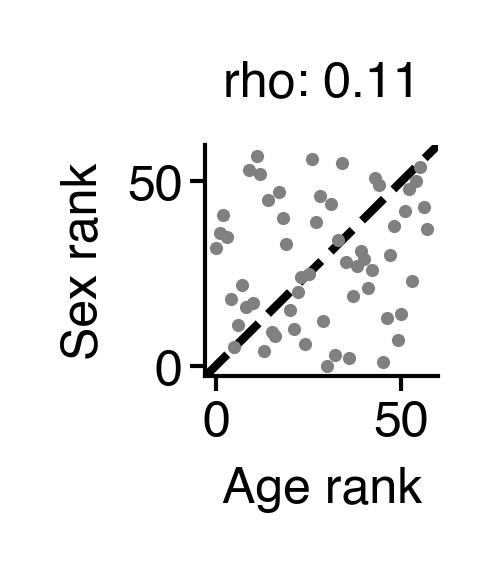

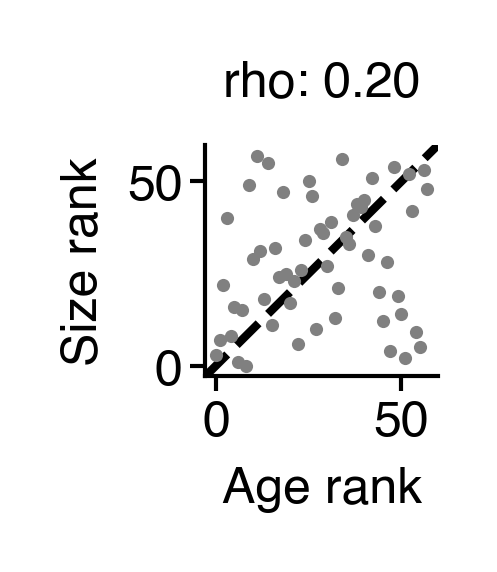

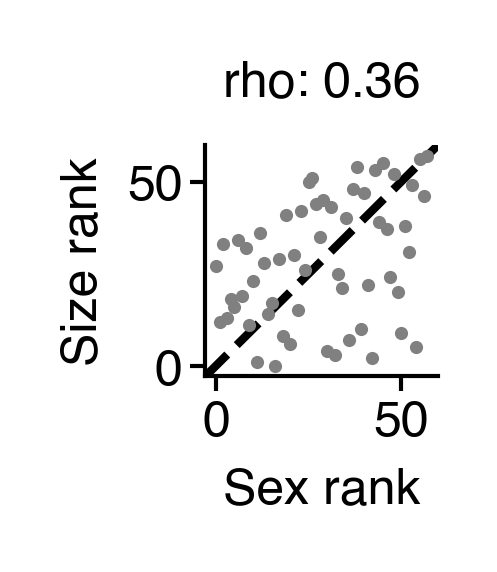

In [83]:
colors = dict(zip(['age', 'sex', 'size'], cc.glasbey[2:]))

for t1, t2 in combinations(['age', 'sex', 'size'], 2):
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    c = rank_df[t1].corr(rank_df[t2], method='spearman')
    ax.scatter(rank_df[t1], rank_df[t2], s=2.5, linewidth=0, color='gray')
    # for _factor, _color in colors.items():
    #     ax.scatter(rank_df.loc[filt_sylls[_factor], t1], rank_df.loc[filt_sylls[_factor], t2], s=5, linewidth=0, color=colors[_factor], label=_factor.capitalize())
    add_identity(ax, ls='--', color='k', zorder=-1)
    # legend(ax)
    ax.set(xlabel=f"{t1.capitalize()} rank", ylabel=f"{t2.capitalize()} rank", title=f"rho: {c:0.2f}")
    sns.despine()

    saver(fig, f"{t1}-{t2}-rank-comparison");

/home/wg41/miniconda3/envs/aging-gpu/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


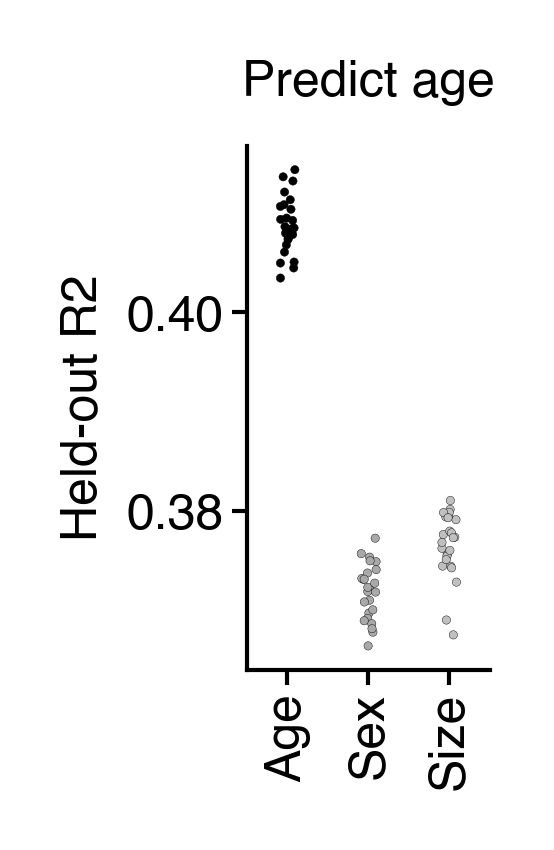

In [84]:
n_repeats = 25
x = []

for rank_grp, _df in filt_sylls.items():
    _values = rank_df[rank_grp].sort_values(ascending=False).index[:top_n].values
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _values]),
            # np.array(syllable_counts_jax[:, _df.values]),
            clf_data["age"],
            # clf_data["bio_age"],
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(clf_data["age"], preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.stripplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict age")
sns.despine()
saver(fig, "predict-age-from-syllables", tight_layout=True);

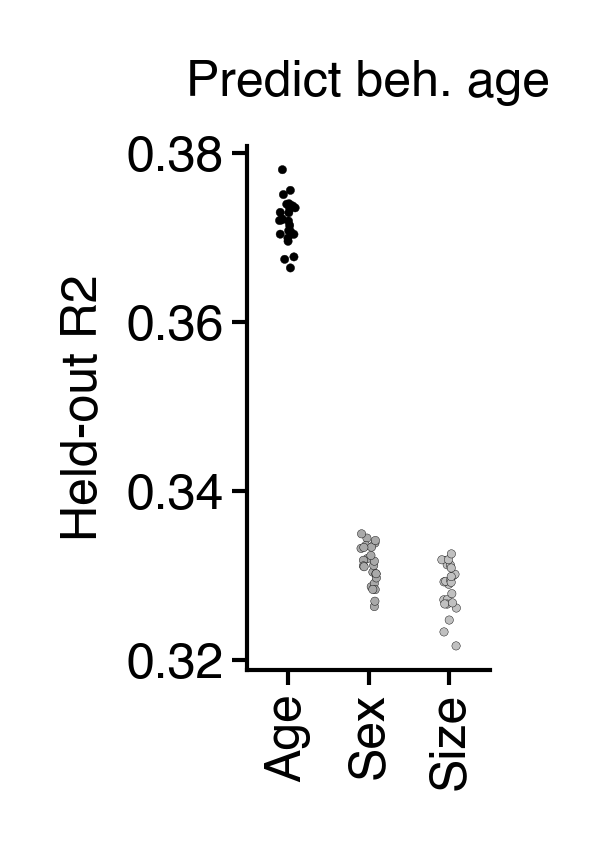

In [85]:
n_repeats = 25
x = []

for rank_grp, _df in filt_sylls.items():
    _values = rank_df[rank_grp].sort_values(ascending=False).index[:top_n].values
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _values]),
            # np.array(syllable_counts_jax[:, _df.values]),
            clf_data["bio_age"],
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(clf_data["age"], preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.stripplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict beh. age")
sns.despine()
saver(fig, "predict-beh-age-from-syllables", tight_layout=True);

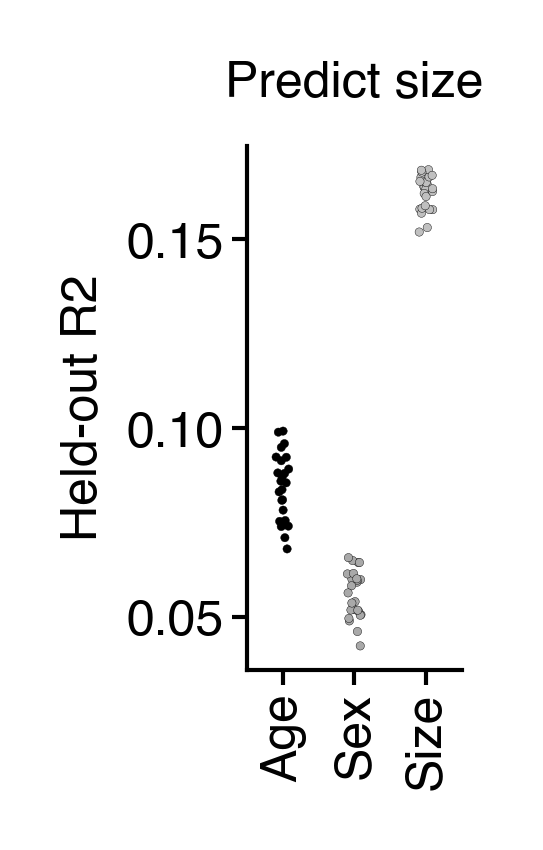

In [86]:
n_repeats = 25
x = []

y = np.array(features['sizes'])

for rank_grp, _df in filt_sylls.items():
    _values = rank_df[rank_grp].sort_values(ascending=False).index[:top_n].values
    for i in range(n_repeats):
        preds = cross_val_predict(
            pipe,
            np.array(syllable_counts_jax[:, _values]),
            # np.array(syllable_counts_jax[:, _df.values]),
            y,
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"r2": r2_score(y, preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)

fig = figure(0.9, 1.4)
ax = sns.stripplot(data=x, x='type', y='r2', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out R2", xlabel="", title="Predict size")
sns.despine()
saver(fig, "predict-size-from-syllables", tight_layout=True);

In [87]:
clf_pipe = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', class_weight='balanced'),
)

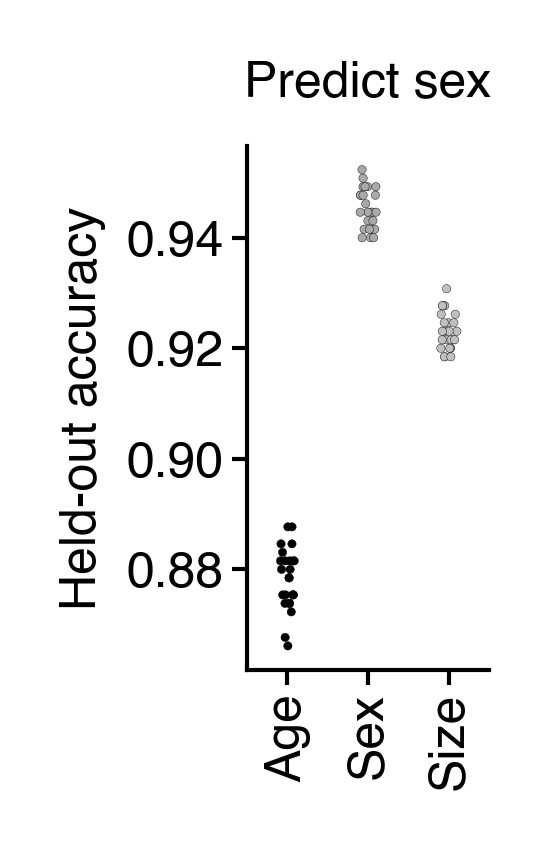

In [88]:
n_repeats = 25
x = []

y = np.argmax(features['mice'], axis=0)

for rank_grp, _df in filt_sylls.items():
    _values = rank_df[rank_grp].sort_values(ascending=False).index[:top_n].values
    for i in range(n_repeats):
        preds = cross_val_predict(
            clf_pipe,
            np.array(syllable_counts_jax[:, _values]),
            # np.array(syllable_counts_jax[:, _df.values]),
            y,
            cv=KFold(n_splits=5, shuffle=True, random_state=i),
            n_jobs=-1,
        )
        x.append({"acc": accuracy_score(y, preds), "type": rank_grp.capitalize()})
x = pd.DataFrame(x)


fig = figure(0.9, 1.4)
ax = sns.stripplot(data=x, x='type', y='acc', hue='type', palette=['k', 'darkgray', 'silver'], size=1, linewidth=0.05)
plt.xticks(rotation=90)
ax.set(ylabel="Held-out accuracy", xlabel="", title="Predict sex")
sns.despine()
saver(fig, "predict-sex-from-syllables", tight_layout=True);

## NMF

### Males

In [89]:
mask = df.index.get_level_values('sex') == 0

nmf_df = pd.DataFrame(dict(age=mdl['true_ages'], bio_age=mdl['bio_ages']), index=df.index).loc[mask].copy()

_age = nmf_df['age'].to_numpy()
nmf_df = nmf_df.sort_values(by='bio_age')
nmf_df['bio_age_map'] = _age
nmf_df = nmf_df.loc[df.index[mask]]

In [90]:
nmf_components = 4
nmf = NMF(n_components=nmf_components, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(df.loc[mask].copy()))
nmf_keys = [f"{c + 1}" for c in range(nmf_components)]
nmf_df[nmf_keys] = scores

In [91]:
# joblib.dump(nmf.components_, '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-nmf-components.p')
# nmf_df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-nmf-scores.parquet')

In [92]:
chron_avg = nmf_df.groupby(level='age')[nmf_keys].mean()
bio_avg = nmf_df.groupby('bio_age_map')[nmf_keys].mean()

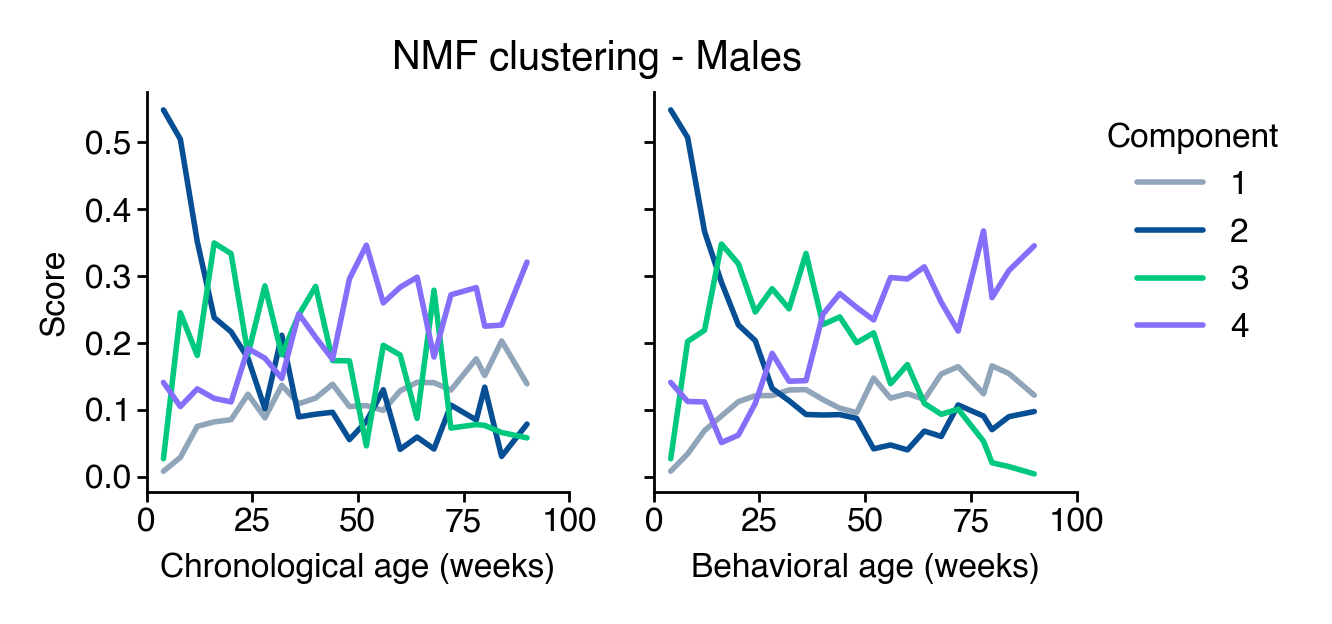

In [93]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True, sharex=True)
    a = chron_avg.plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = bio_avg.plot(ax=ax[1])
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score", xlim=(0, 100))
    legend(a2, title="Component")
    sns.despine()
    fig.suptitle("NMF clustering - Males")
    saver(fig, "nmf-components-pre-post-sorting-blue-colors");

### Females

In [94]:
mask = df.index.get_level_values('sex') == 1

nmf_df = pd.DataFrame(dict(age=mdl['true_ages'], bio_age=mdl['bio_ages']), index=df.index).loc[mask].copy()

_age = nmf_df['age'].to_numpy()
nmf_df = nmf_df.sort_values(by='bio_age')
nmf_df['bio_age_map'] = _age
nmf_df = nmf_df.loc[df.index[mask]]

In [95]:
nmf = NMF(n_components=nmf_components, random_state=0, max_iter=2_000)
scores = nmf.fit_transform(minmax(df.loc[mask].copy()))
nmf_keys = [f"{c + 1}" for c in range(nmf_components)]
nmf_df[nmf_keys] = scores

In [96]:
# joblib.dump(nmf.components_, '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-nmf-components.p')
# nmf_df.to_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-nmf-scores.parquet')

In [97]:
chron_avg = nmf_df.groupby(level='age')[nmf_keys].mean()
bio_avg = nmf_df.groupby('bio_age_map')[nmf_keys].mean()

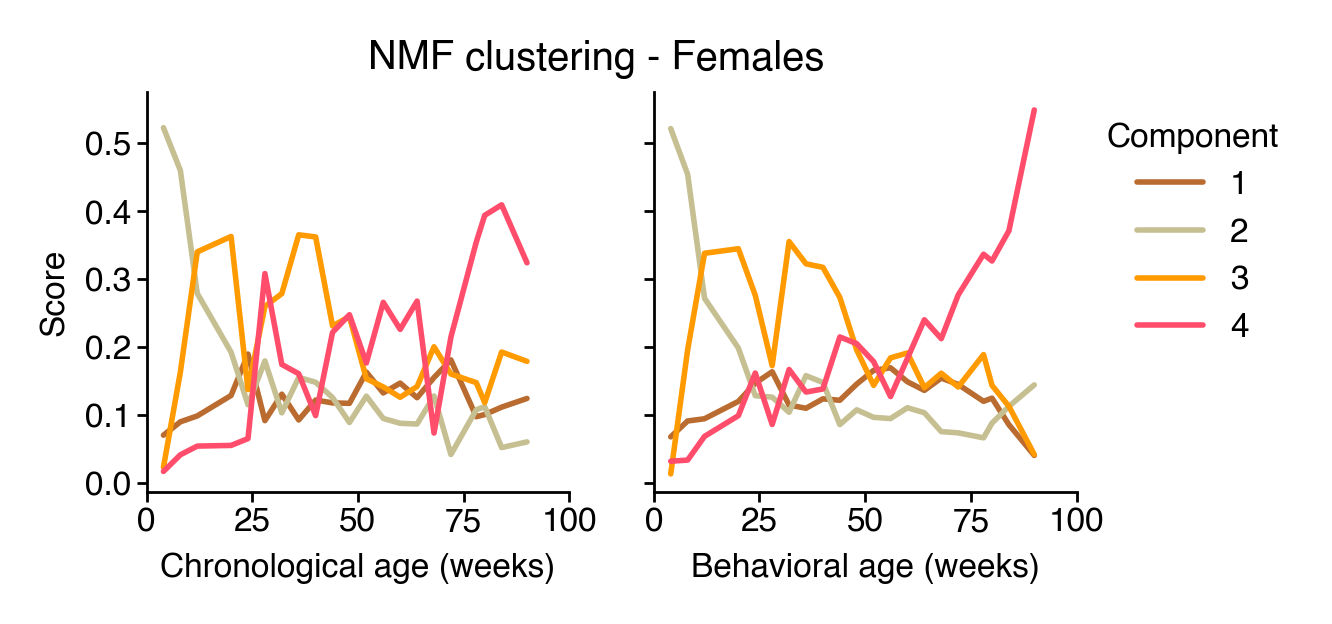

In [98]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig, ax = plt.subplots(1, 2, figsize=(3, 1.3), sharey=True, sharex=True)
    a = chron_avg.plot(ax=ax[0], legend=False)
    a.set(xlabel="Chronological age (weeks)", ylabel="Score")
    a2 = bio_avg.plot(ax=ax[1])
    legend(a2, title="Component")
    a2.set(xlabel="Behavioral age (weeks)", ylabel="Score", xlim=(0, 100))
    sns.despine()
    fig.suptitle("NMF clustering - Females")
    saver(fig, "female-nmf-components-pre-post-sorting-blue-colors");

## K-means

In [58]:
from itertools import combinations
from toolz import groupby, valmap, compose
from toolz.curried import get, pluck

from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score

In [59]:
class_df = pd.read_csv(
    "../super-hell-week-2024-05-09/v11_syllable_labels_v3.csv", index_col="Original ID", usecols=range(4)
)


def get_class(syll):
    return class_df.loc[syll, "Class"]

### Males + females

In [101]:
kmeans_df = df.copy()
kmeans_df['bio_age'] = mdl['bio_ages']
_age = kmeans_df.index.get_level_values('age')
kmeans_df = kmeans_df.sort_values(by='bio_age')
kmeans_df['bio_age_map'] = _age.to_numpy()
kmeans_df = kmeans_df.drop(columns=['bio_age']).set_index('bio_age_map', append=True)

In [102]:
silhouettes = []

for c, seed in tqdm(product(range(2, 7), range(100))):
    # mm_df = minmax(kmeans_df.sample(frac=1, replace=True, random_state=seed).groupby('bio_age_map').mean())
    sample = kmeans_df.groupby('sex').sample(frac=1, replace=True, random_state=seed)
    # sample = sample.groupby(['sex', 'bio_age_map']).mean()
    sample = sample.groupby('sex').transform(minmax).groupby(['sex', 'bio_age_map']).mean()
    # mm_df = minmax(sample.reset_index().melt(id_vars=['sex', 'bio_age_map'], value_name='counts').pivot_table(index='bio_age_map', columns=['sex', 'syllables'], values='counts')).fillna(0)
    mm_df = sample.reset_index().melt(id_vars=['sex', 'bio_age_map'], value_name='counts').pivot_table(index='bio_age_map', columns=['sex', 'syllables'], values='counts').fillna(0)
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)

    aic = compute_aic(centroid, labels, mm_df.T.to_numpy())
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia, aic=aic))

silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

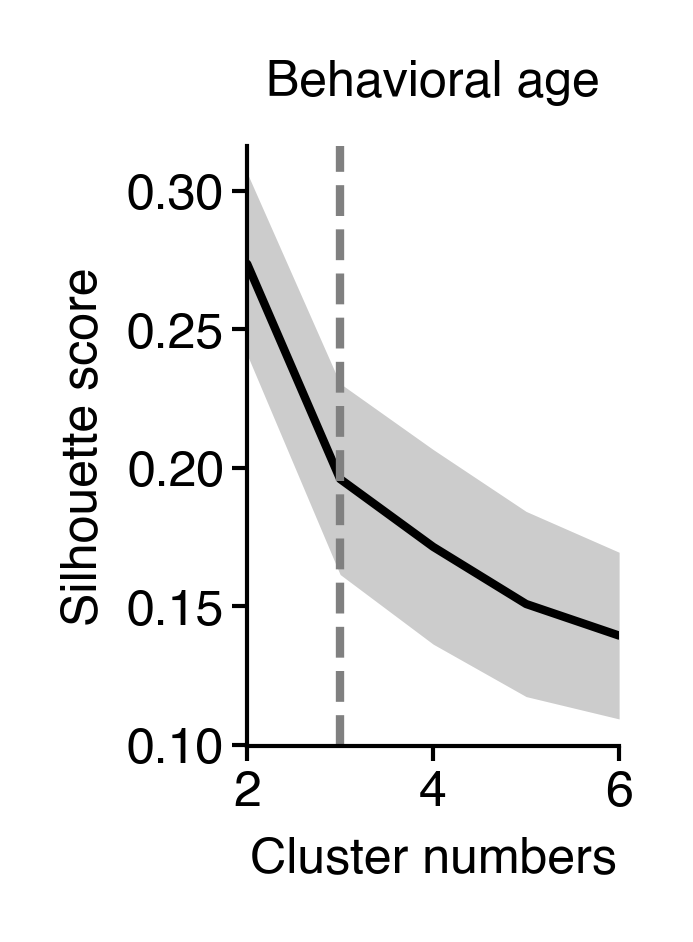

In [103]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
# saver(fig, "male-female-k-means-cluster-silhouette-score-chron-age");

In [104]:
# mm_df = minmax(kmeans_df.groupby('age').mean())
sample = kmeans_df.groupby(['sex', 'bio_age_map']).mean()
mm_df = minmax(sample.reset_index().melt(id_vars=['sex', 'bio_age_map'], value_name='counts').pivot_table(index='bio_age_map', columns=['sex', 'syllables'], values='counts')).fillna(0)

n_clust = 3

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(500)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/500 [00:00<?, ?it/s]

In [105]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [106]:
best_kmeans.head(2)

0         1         2  seed      s_sc
bio_age_map                                              
4            0.427725  0.434687  0.172651   164  0.211342
8            0.410784  0.486113  0.329682   164  0.211342

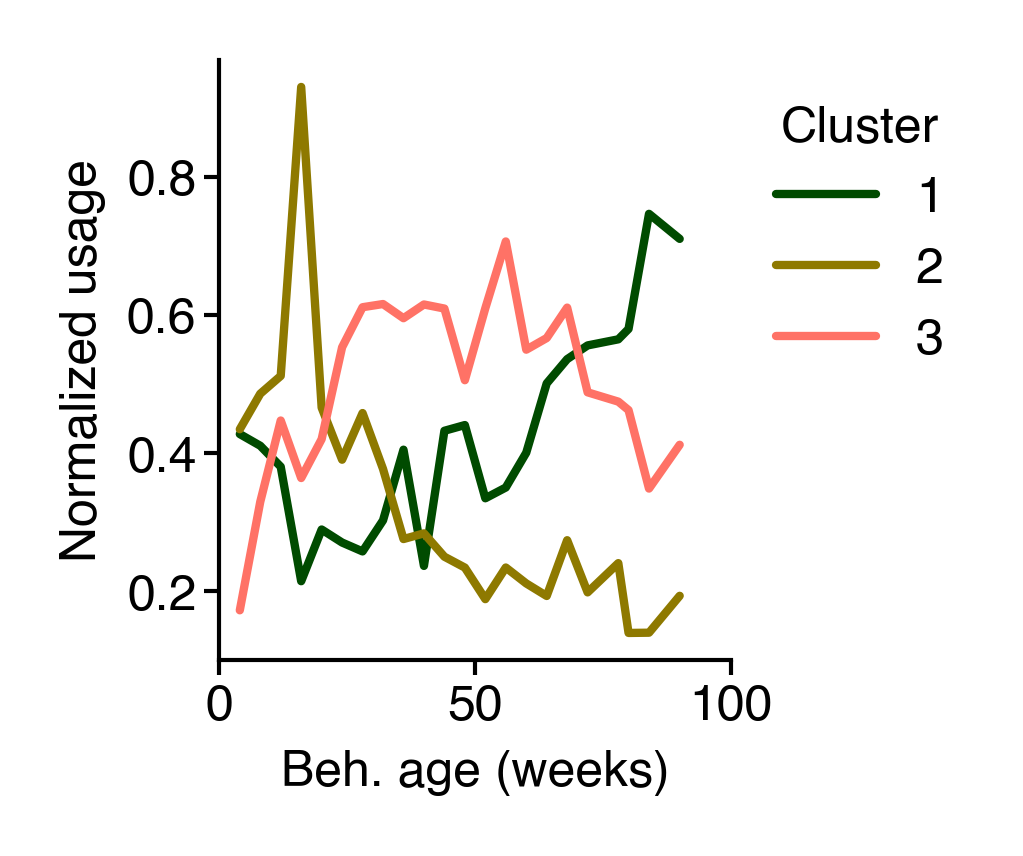

In [107]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey[20:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    # ax.set(xlabel="Chron. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    ax.set(xlabel="Beh. age (weeks)", ylabel="Normalized usage", xlim=(0, 100))
    sns.despine()
    # saver(fig, "male-female-k-means-cluster-chron-age");

In [108]:
cluster_df = []
for k, v in syllable_groups[best_seed].items():
    for item in v:
        cluster_df.append(dict(cluster=k, sex=item[0], syllable=item[1]))
cluster_df = pd.DataFrame(cluster_df)

In [109]:
cluster_df['class'] = cluster_df['syllable'].map(get_class)

In [110]:
cluster_df

cluster  sex  syllable        class
0          2    0         0      Rear up
1          2    0         2          Run
2          2    0         4          Run
3          2    0        14  Investigate
4          2    0        16        Groom
..       ...  ...       ...          ...
111        1    1        60      Rear up
112        1    1        69         Walk
113        1    1        73      Rear up
114        1    1        76      Rear up
115        1    1        85      Rear up

[116 rows x 4 columns]

In [111]:
order = cluster_df.sort_values(by=['sex', 'cluster']).query('sex == 0')['syllable'].values

<Axes: xlabel='syllable', ylabel='cluster'>

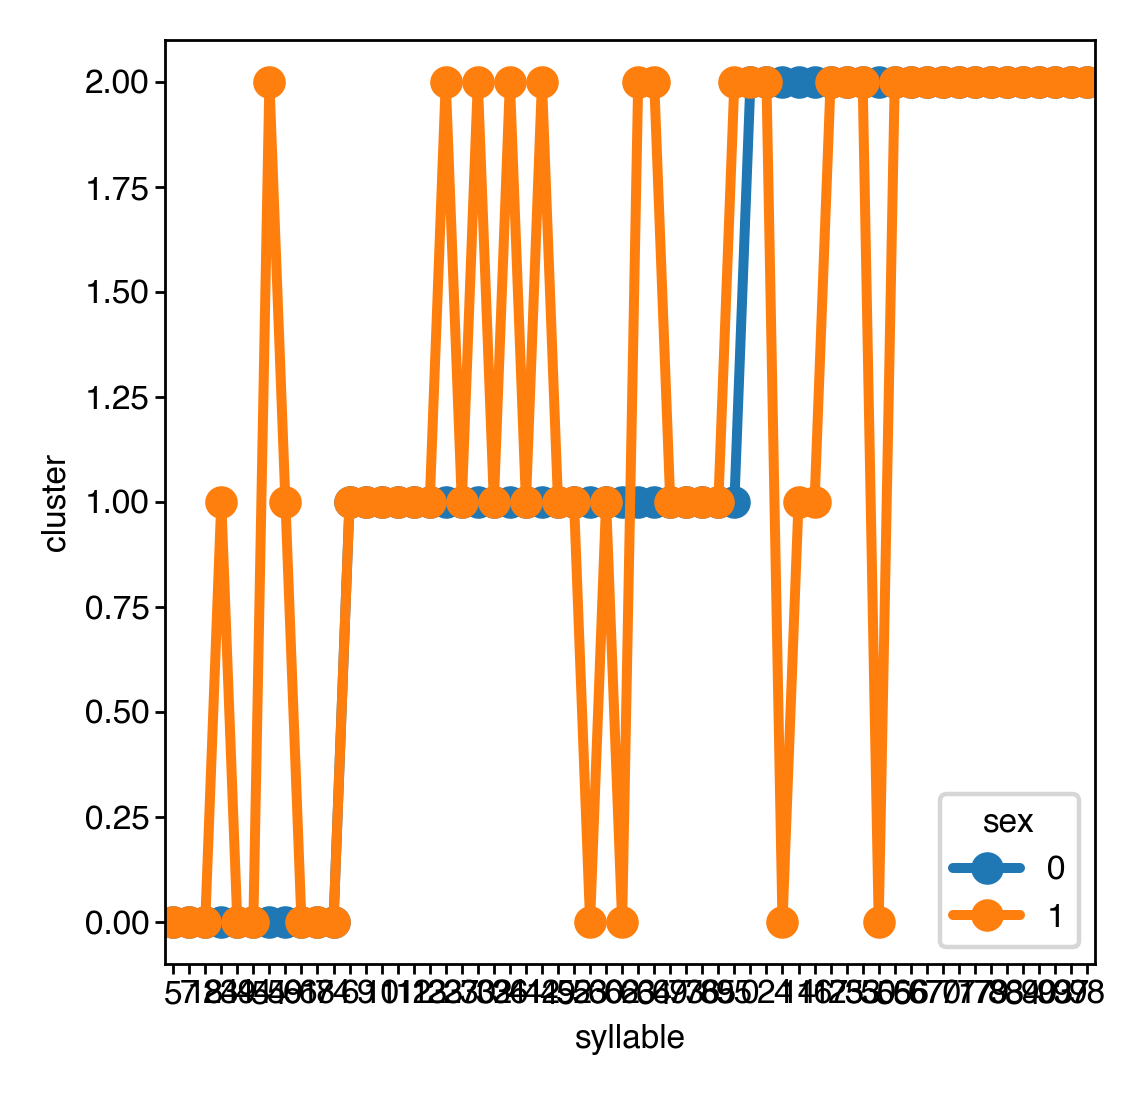

In [112]:
sns.pointplot(data=cluster_df, x='syllable', y='cluster', hue='sex', order=order)

In [113]:
# _classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

# start_letter = ord('a')

# row1 = ''.join(chr(start_letter + i) for i in range(n_clust))
# row2 = chr(start_letter + n_clust) * n_clust

# mosaic = '\n'.join([row1, row2])

# fig, ax = plt.subplot_mosaic(mosaic, figsize=(2.6, 1.8), gridspec_kw={'wspace': 0.3, 'hspace': 0.4})

# for _a, ((k, sylls), color) in enumerate(zip(_classes.items(), cc.glasbey_cool[15:])):
#     letter = chr(_a + 97)
#     a = ax[letter]
#     mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
#     a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
#     a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))
# ax['a'].set(ylabel="Normalized usage")
# ax['b'].set(xlabel="Chron. age (wks)")

# with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
#     a = ax[chr(start_letter + n_clust)]
#     cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
#     sns.heatmap(cf_df.T, ax=a, cmap='mako', vmax=10, cbar_kws=dict(label="Counts"))
#     a.set(xlabel="", ylabel="Cluster")
#     # cf_df = pd.DataFrame(class_freqs).fillna(0).rename(columns=lambda x: x+1)
#     # cf_df = cf_df.loc[cf_df.sum(1).sort_values(ascending=False).index]
#     # a = cf_df.plot(kind='bar', ax=a, width=0.6, linewidth=0)
#     # legend(a, title="Cluster")
#     # a.set(ylabel="Counts", xlabel="", ylim=(0, cf_df.max().max()))
# sns.despine()
# saver(fig, "male-k-means-cluster-all-sylls-chron-age");

### males

#### sort by chron age

In [63]:
mask = df.index.get_level_values('sex') == 0

In [115]:
silhouettes = []

_males = df.loc[mask].copy()
for c, seed in tqdm(product(range(2, 7), range(100))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('age').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    aic = compute_aic(centroid, labels, mm_df.T.to_numpy())
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia, aic=aic))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

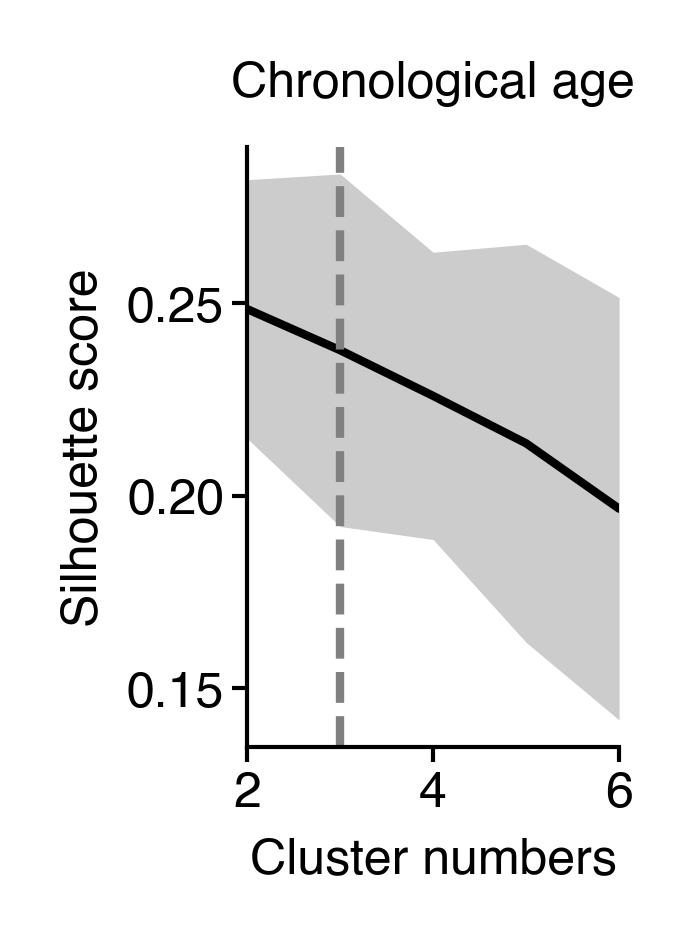

In [116]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "male-k-means-cluster-silhouette-score-chron-age");

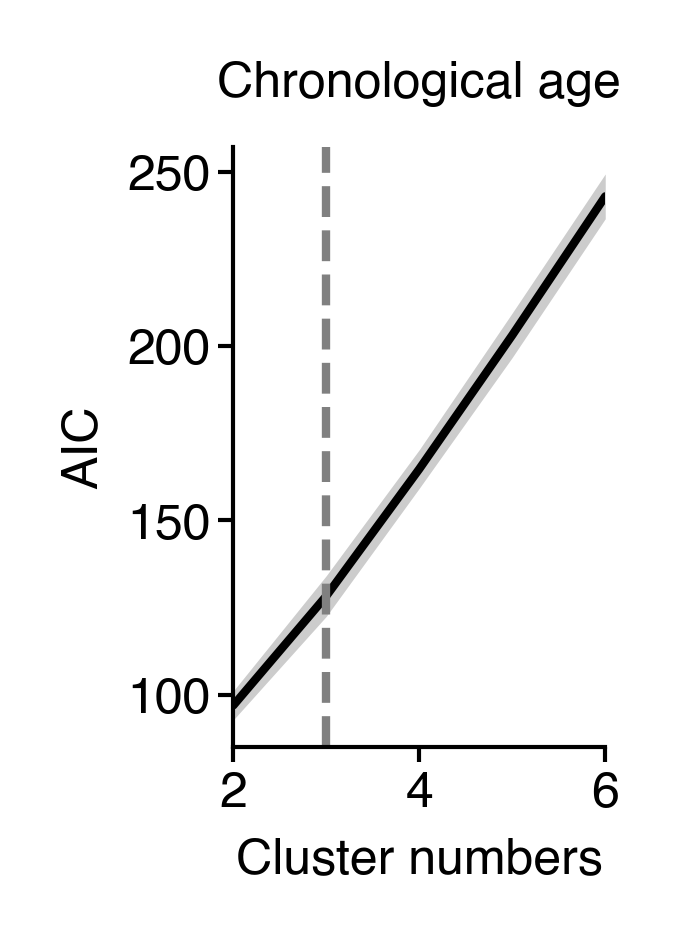

In [117]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="aic",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="AIC", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "male-k-means-cluster-aic-chron-age");

In [72]:
_males = df.loc[mask].copy()
mm_df = minmax(_males.groupby('age').mean())

n_clust = 3

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(500)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/500 [00:00<?, ?it/s]

In [119]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [120]:
best_kmeans.head(2)

0         1         2  seed      s_sc
age                                              
4    0.121649  0.161167  0.771010     6  0.284515
8    0.597271  0.225964  0.860119     6  0.284515

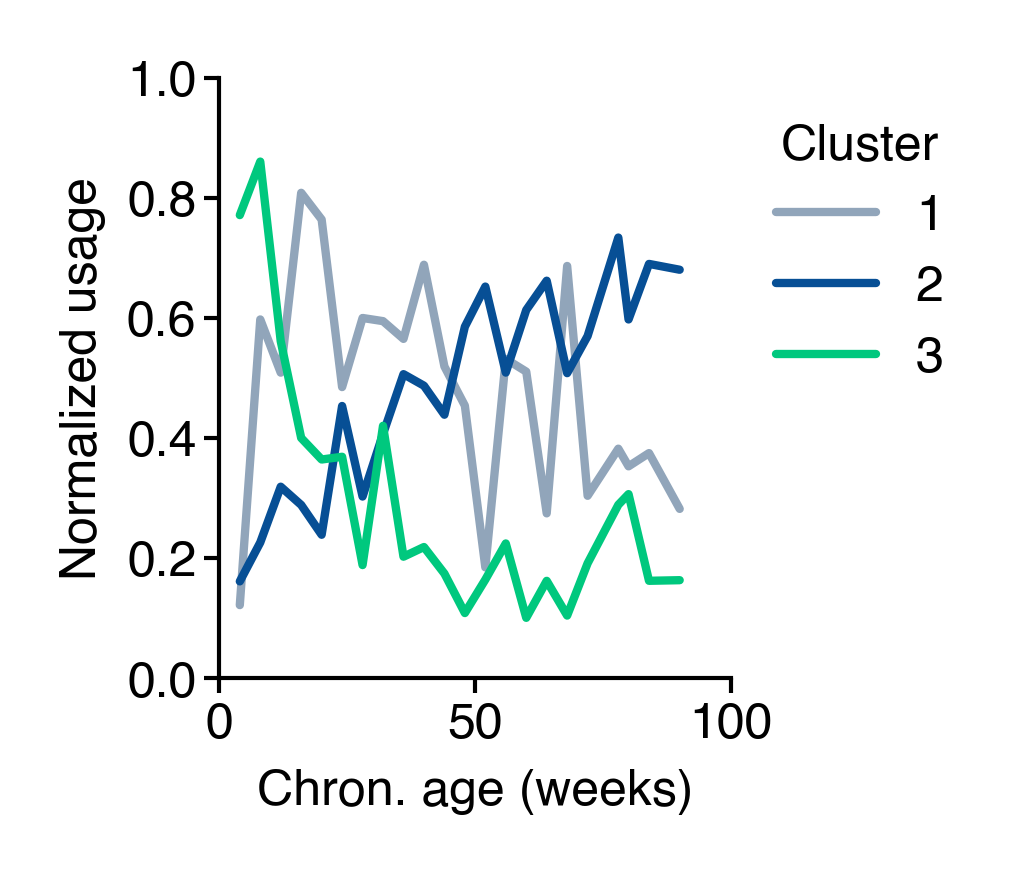

In [121]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Chron. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "male-k-means-cluster-chron-age");

#### Cluster version with 4 plots, one for each cluster

In [60]:
def plot_kmeans_clusters(classes, class_freqs, is_chron=True, sex='male'):
    colormap = cc.glasbey_cool[15:] if sex == 'male' else cc.glasbey_warm[11:]

    start_letter = ord('a')

    mosaic = ''.join(chr(start_letter + i) for i in range(n_clust))
    mosaic += '\n' + ''.join(chr(start_letter + i + n_clust) for i in range(n_clust))

    fig, ax = plt.subplot_mosaic(mosaic, figsize=(2, 1.8), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})

    cf_df = pd.DataFrame(class_freqs).fillna(0)
    plt_class_sorting = cf_df.mean(1).sort_values(ascending=True).index

    for _a, ((k, sylls), color) in enumerate(zip(classes.items(), colormap)):
        letter = chr(_a + 97)

        # make lineplot
        a = ax[letter]
        mm_df[sylls].plot(ax=a, legend=False, color='#ccc', alpha=0.5, lw=0.7)
        a.plot(mm_df[sylls].mean(1), color=color, lw=1.5)
        a.set(title=f"Cluster #{k + 1}", xlabel="", ylim=(0, 1), yticks=(0, 1), xlim=(0, 100))

        # make histogram
        a = ax[chr(k + 97 + n_clust)]
        a = cf_df.loc[plt_class_sorting, k].plot.barh(color=color, ax=a, linewidth=0, width=0.6)
        a.set(xlabel="", ylabel="", xlim=(0, cf_df.max().max()))
        if k != 0:
            a.set(yticklabels=[])

    ax['a'].set(ylabel="Normalized usage")
    ax['b'].set(xlabel="Chron. age (wks)" if is_chron else "Beh. age (wks)")
    ax['e'].set(xlabel="Counts")

    sns.despine()

    age_type = "chron" if is_chron else "beh"
    saver(fig, f"{sex}-k-means-cluster-all-sylls-{age_type}-age-v2")

In [123]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)

_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

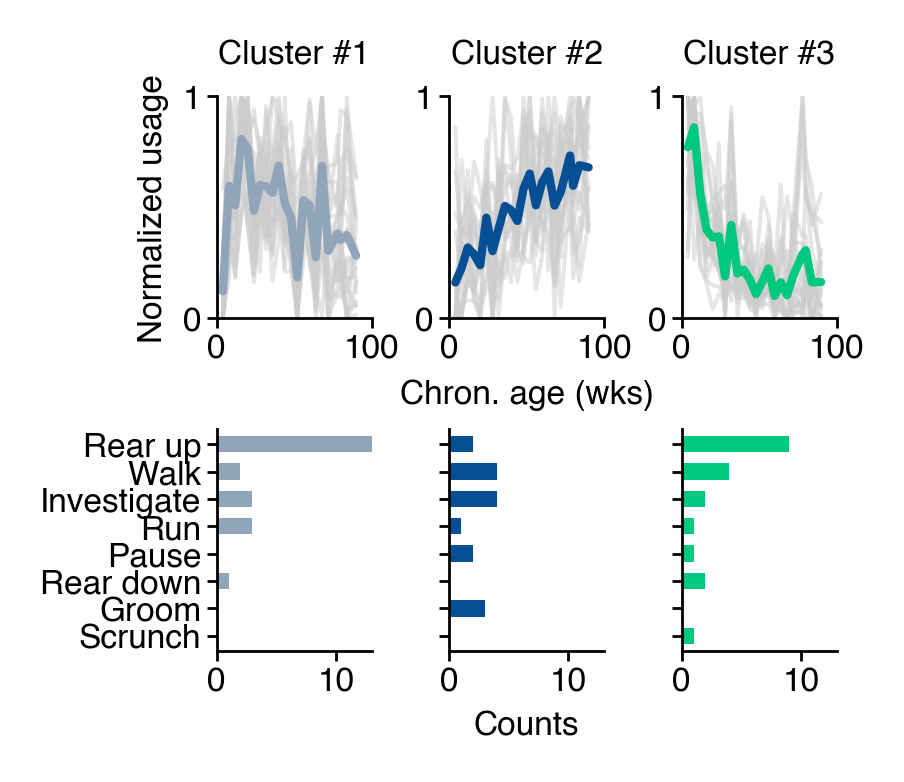

In [124]:
plot_kmeans_clusters(_classes, class_freqs, is_chron=True, sex='male')

In [125]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-chron-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-chron-age.p']

#### Sort by bio age

In [73]:
silhouettes = []

_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
unique_ages = _males.index.get_level_values('age').unique().values
d = cdist(unique_ages[:, None], _males[['bio_age']], metric='cityblock')
age_indices = np.argmin(d, axis=0)
new_age_mapped = unique_ages[age_indices]

_males['bio_age_map'] = new_age_mapped
_males = _males.drop(columns=['bio_age']).set_index('bio_age_map', append=True)

for c, seed in tqdm(product(range(2, 7), range(100))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('bio_age_map').mean())
    pd_mtx = squareform(pdist(mm_df.T, metric='correlation'))

    cols = mm_df.columns.to_numpy()
    col_map = dict(map(reversed, enumerate(cols)))

    def to_syll_array(sylls):
        return np.array([col_map[s] for s in sylls])

    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    aic = compute_aic(centroid, labels, mm_df.T.to_numpy())

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)

    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia, aic=aic))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

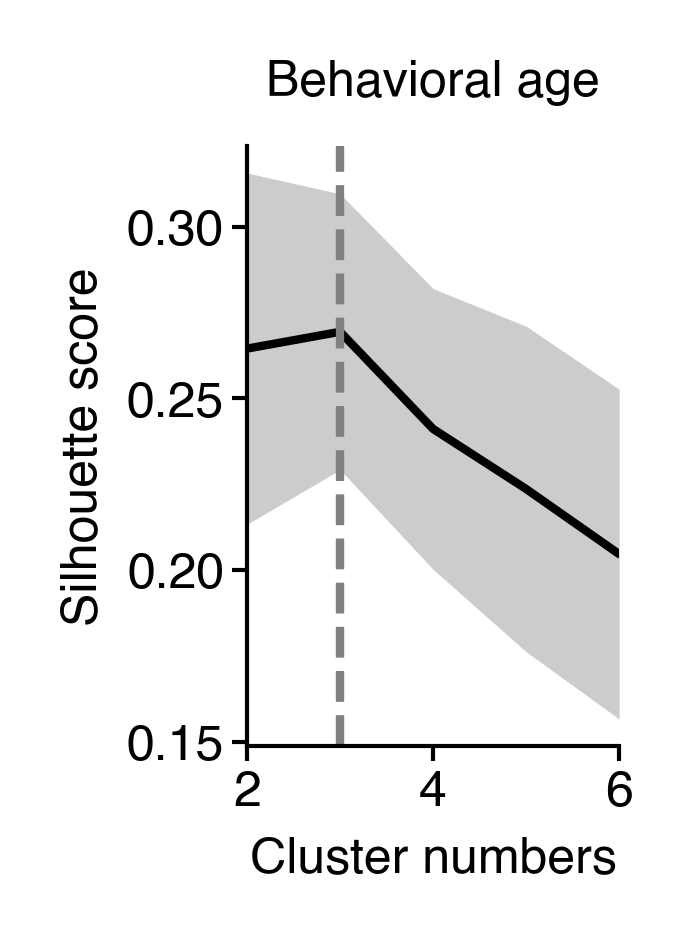

In [74]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "male-k-means-cluster-silhouette-score-beh-age");

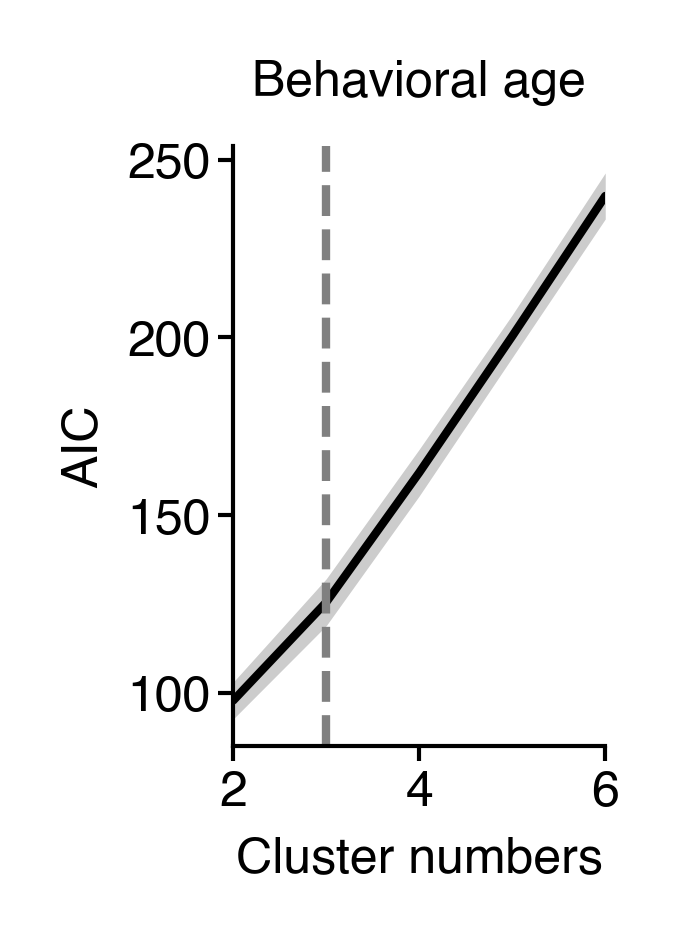

In [75]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="aic",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="AIC", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "male-k-means-cluster-aic-beh-age");

In [76]:
mm_df = minmax(_males.groupby('bio_age_map').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(500)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

    centroid_dfs.append(k)

  0%|          | 0/500 [00:00<?, ?it/s]

In [77]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [78]:
best_kmeans.head(2)

0         1         2  seed      s_sc
bio_age_map                                              
4            0.158517  0.790285  0.149263     0  0.327586
8            0.281328  0.874246  0.494942     0  0.327586

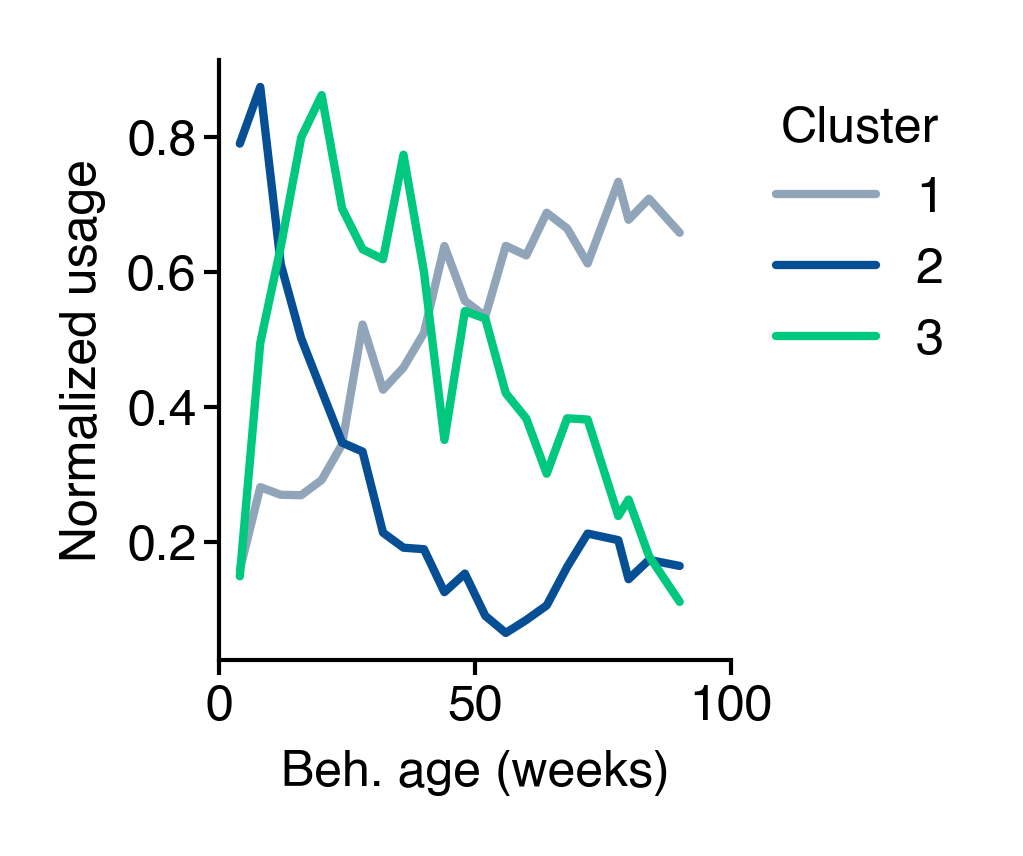

In [79]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_cool[15:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Beh. age (weeks)", ylabel="Normalized usage", xlim=(0, 100))
    sns.despine()
    saver(fig, "male-k-means-cluster-beh-age");

In [80]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

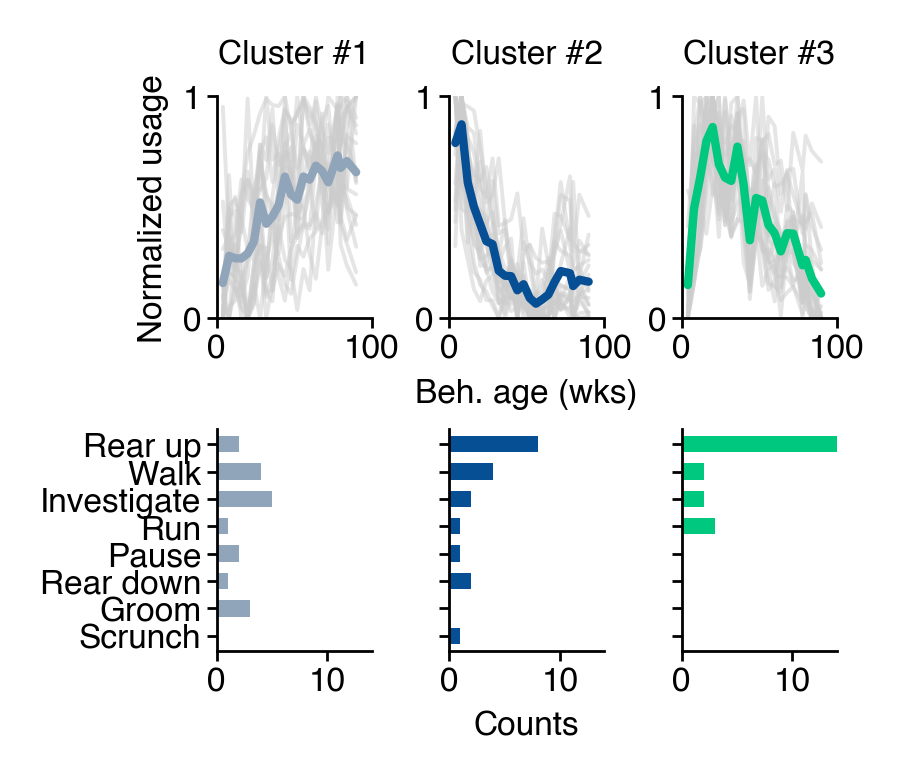

In [81]:
plot_kmeans_clusters(_classes, class_freqs, is_chron=False, sex='male')

In [82]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-beh-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-beh-age.p']

### females

In [84]:
mask = df.index.get_level_values('sex') == 1

In [85]:
silhouettes = []

_males = df.loc[mask].copy()
for c, seed in tqdm(product(range(2, 7), range(100))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('age').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    aic = compute_aic(centroid, labels, mm_df.T.to_numpy())
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia, aic=aic))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

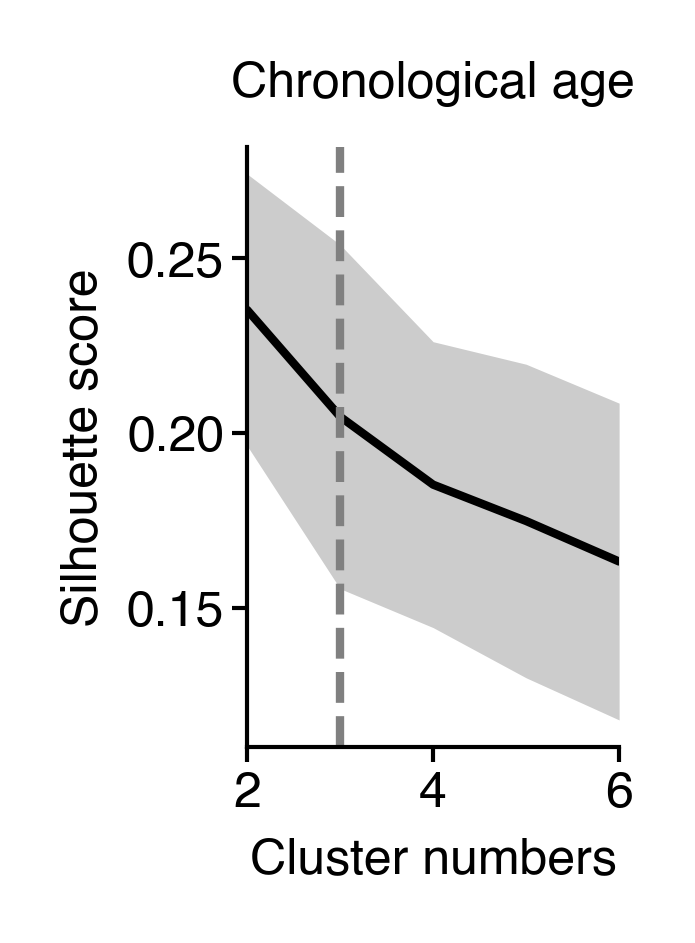

In [86]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "female-k-means-cluster-silhouette-score-chron-age");

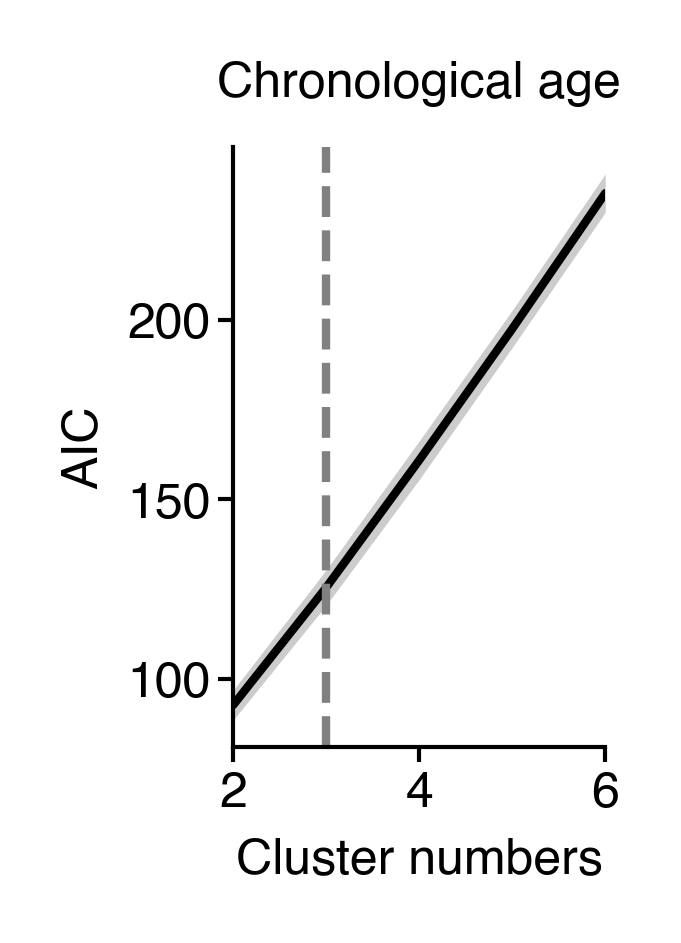

In [87]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="aic",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="AIC", xlabel="Cluster numbers", xlim=(2, 6), title="Chronological age")
sns.despine()
saver(fig, "female-k-means-cluster-aic-chron-age");

In [88]:
_males = df.loc[mask].copy()
mm_df = minmax(_males.groupby('age').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(500)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/500 [00:00<?, ?it/s]

In [89]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [90]:
best_kmeans.head(2)

0         1         2  seed      s_sc
age                                              
4    0.464656  0.047022  0.658796    80  0.263291
8    0.436127  0.260715  0.746181    80  0.263291

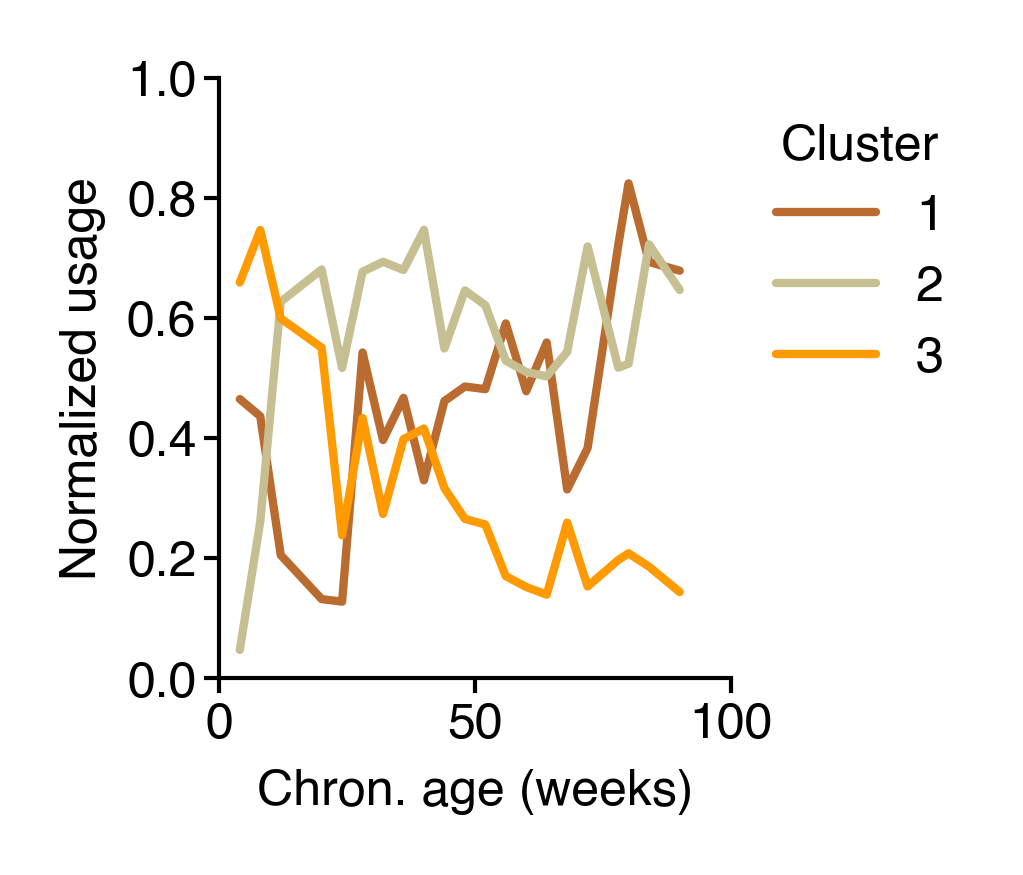

In [91]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Chron. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "female-k-means-cluster-chron-age");

In [92]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

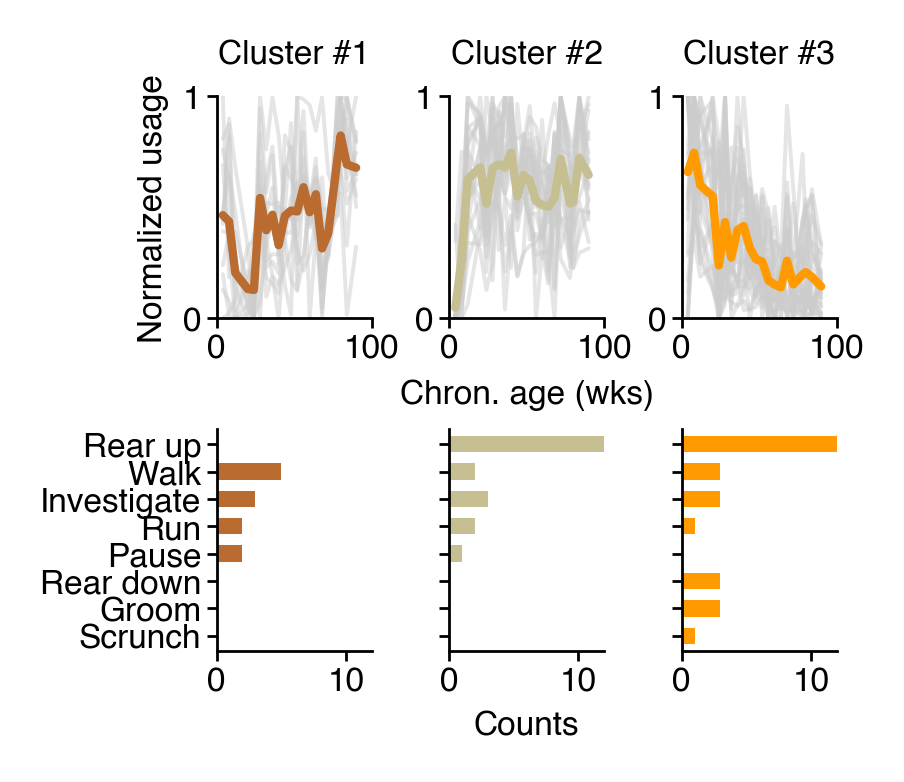

In [93]:
plot_kmeans_clusters(_classes, class_freqs, is_chron=True, sex='female')

In [94]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-chron-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-chron-age.p']

#### Sort by bio age

In [95]:
silhouettes = []

_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
unique_ages = _males.index.get_level_values('age').unique().values
d = cdist(unique_ages[:, None], _males[['bio_age']], metric='cityblock')
age_indices = np.argmin(d, axis=0)
new_age_mapped = unique_ages[age_indices]

_males['bio_age_map'] = new_age_mapped
_males = _males.drop(columns=['bio_age']).set_index('bio_age_map', append=True)

for c, seed in tqdm(product(range(2, 7), range(100))):
    mm_df = minmax(_males.sample(frac=1, replace=True, random_state=seed).groupby('bio_age_map').mean())
    centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)
    aic = compute_aic(centroid, labels, mm_df.T.to_numpy())
    silhouettes.append(dict(n_clust=c, seed=seed, s_sc=silhouette_score(mm_df.T, labels), sse=inertia, aic=aic))
silhouettes = pd.DataFrame(silhouettes)

0it [00:00, ?it/s]

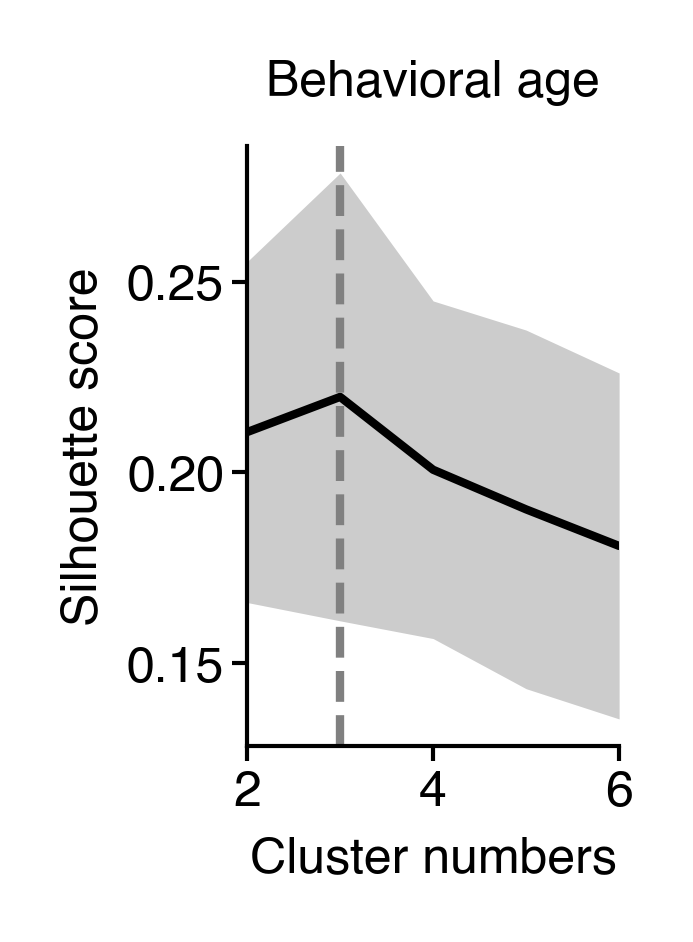

In [96]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="s_sc",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="Silhouette score", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "female-k-means-cluster-silhouette-score-beh-age");

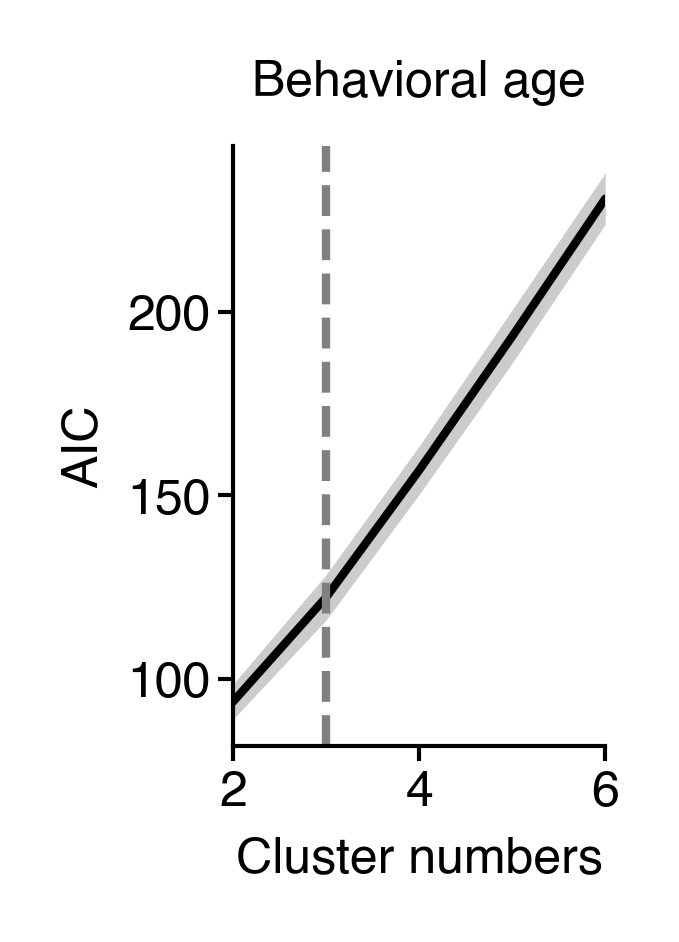

In [97]:
fig = figure(0.8, 1.3)
ax = sns.lineplot(
    data=silhouettes,
    x="n_clust",
    y="aic",
    errorbar=("sd", 2),
    err_kws=dict(lw=0),
    color="k",
)
ax.axvline(3, color="gray", ls="--")
ax.set(ylabel="AIC", xlabel="Cluster numbers", xlim=(2, 6), title="Behavioral age")
sns.despine()
saver(fig, "female-k-means-cluster-aic-beh-age");

In [98]:
centroid, labels, inertia = k_means(mm_df.T, c, random_state=seed)

In [99]:
_males = df.loc[mask].copy()
_males['bio_age'] = mdl['bio_ages'][mask]
_age = _males.index.get_level_values('age')
_males = _males.sort_values(by='bio_age')
_males['bio_age_map'] = _age.to_numpy()
_males = _males.loc[df.index[mask]].drop(columns=['bio_age']).set_index('bio_age_map', append=True)

mm_df = minmax(_males.groupby('bio_age_map').mean())

centroid_dfs = []
syllable_groups = {}

for seed in tqdm(range(500)):
    centroid, labels, inertia = k_means(mm_df.T, n_clust, random_state=seed)
    s_sc = silhouette_score(mm_df.T, labels)

    k = pd.DataFrame(centroid.T, index=mm_df.index)
    k['seed'] = seed
    k['s_sc'] = s_sc
    centroid_dfs.append(k)

    groups = groupby(get(0), zip(labels, mm_df.columns))
    groups = valmap(compose(list, pluck(1)), groups)
    syllable_groups[seed] = groups

  0%|          | 0/500 [00:00<?, ?it/s]

In [100]:
best_kmeans = max(centroid_dfs, key=lambda x: x['s_sc'].max())
best_seed = best_kmeans['seed'].iloc[0]

In [101]:
best_kmeans.head(2)

0         1         2  seed      s_sc
bio_age_map                                              
4            0.446580  0.114610  0.650271     5  0.284411
8            0.279297  0.387315  0.835429     5  0.284411

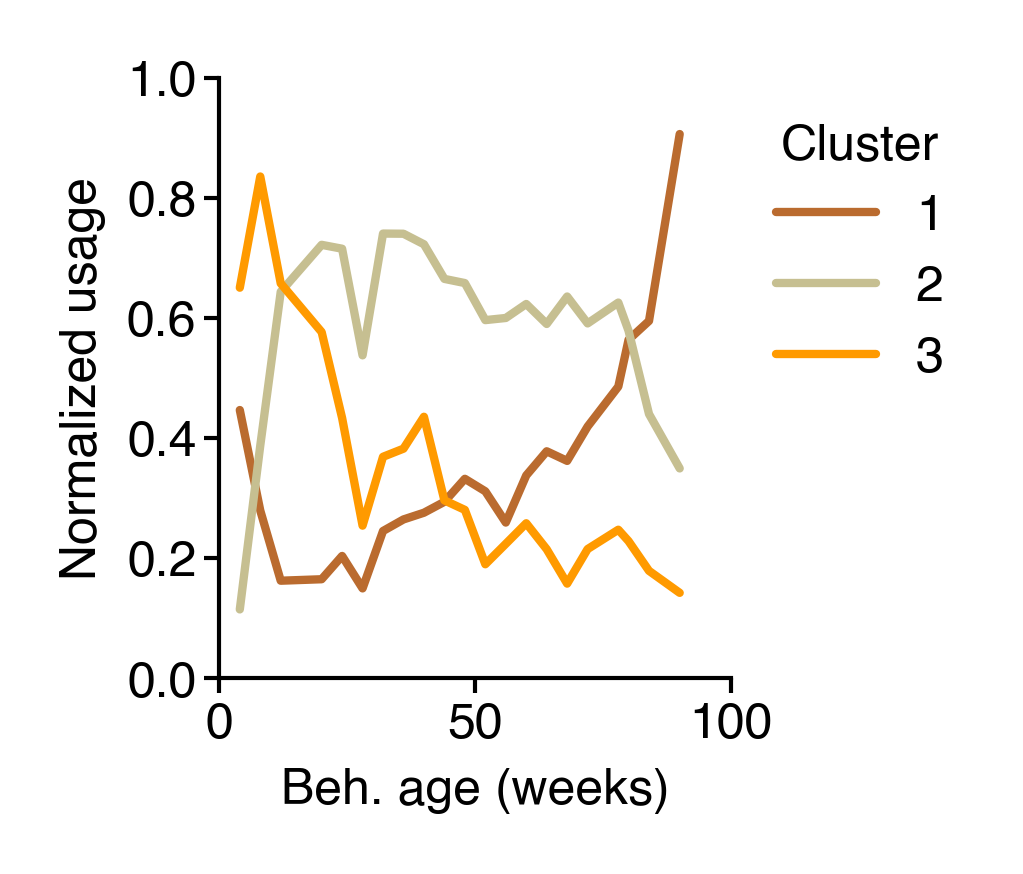

In [102]:
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=cc.glasbey_warm[11:])}):
    fig = figure(1.1, 1.3)
    ax = fig.gca()
    ax = best_kmeans.drop(columns=['seed', 's_sc']).rename(columns=lambda x: x + 1).plot(ax=ax)
    legend(ax, title="Cluster")
    ax.set(xlabel="Beh. age (weeks)", ylabel="Normalized usage", xlim=(0, 100), ylim=(0, 1))
    sns.despine()
    saver(fig, "female-k-means-cluster-beh-age");

In [103]:
syll_classes = valmap(lambda x: list(map(get_class, x)), syllable_groups[best_seed])
# sort classes
syll_classes = dict(sorted(syll_classes.items(), key=get(0)))

class_freqs = valmap(lambda x: pd.Series(x).value_counts(), syll_classes)
_classes = dict(sorted(syllable_groups[best_seed].items(), key=lambda item: item[0]))

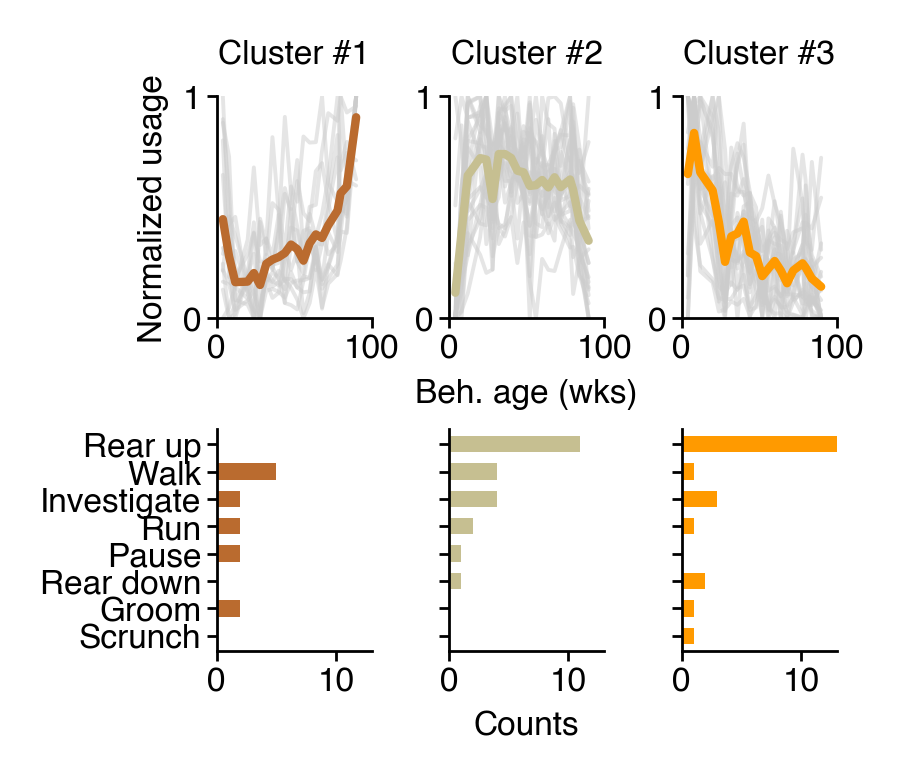

In [104]:
plot_kmeans_clusters(_classes, class_freqs, is_chron=False, sex='female')

In [105]:
joblib.dump(syllable_groups[best_seed], '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-beh-age.p')

['/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-beh-age.p']

## Show shuffles/controls

In [158]:
from scipy.stats import ttest_ind

In [159]:
# features = {
#     "ages": age,  # models >= 1
#     "counts": syllable_counts_jax + 1,  # models >= 1
#     "sizes": pd.concat([sizes_col, female_sizes_col]).to_numpy(),  # models > 1
#     "mice": sex_id,
# }

# age_sd = 0.04

# hypparams = {
#     "log_age": True,
#     "min_age": 3,
#     "max_age": 130,
#     "age_sd": age_sd,
#     "n_age_samples": 1000,
#     "n_splines": 4,
#     "n_syllables": syllable_counts_jax.shape[1],
#     "n_development_splines": 4,
#     "scale": 400,
#     "normalize_by_softmax": True,
#     "n_keep_sylls": 25,
#     "n_sessions": len(syllable_counts_jax),
#     "n_animals": len(sex_id),
#     "lr": 0.25,
#     "n_opt_iter": 1300,
# }

In [160]:
n_repeats = 25

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl3 = masked_xval(features, hyp_copy, 5, n_repeats=n_repeats)
r2_3 = list(pluck('heldout_r2_total_v3', mdl3.values()))
ll_3 = list(pluck('heldout_ll', mdl3.values()))
print(np.mean(r2_3))
del mdl3

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl2 = masked_xval(features, hyp_copy, 2, n_repeats=n_repeats)
r2_2 = list(pluck('heldout_r2_total_v3', mdl2.values()))
ll_2 = list(pluck('heldout_ll', mdl2.values()))
print(np.mean(r2_2))
del mdl2

In [ ]:
ttest_ind(r2_2, r2_3, alternative='less')

In [ ]:
ttest_ind(ll_2, ll_3, alternative='less')

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl1 = masked_xval(features, hyp_copy, 1, n_repeats=n_repeats)
r2_1 = list(pluck('heldout_r2_total_v3', mdl1.values()))
ll_1 = list(pluck('heldout_ll', mdl1.values()))
print(np.mean(r2_1))
del mdl1

In [ ]:
hyp_copy = deepcopy(hypparams)
mdl0 = masked_xval(features, hyp_copy, 0, n_repeats=n_repeats)
r2_0 = list(pluck('heldout_r2_total_v3', mdl0.values()))
ll_0 = list(pluck('heldout_ll', mdl0.values()))
print(np.mean(r2_0))
del mdl0

In [ ]:
hyp_copy = deepcopy(hypparams)
hyp_copy['age_sd'] = 1e-3
mdl0_1 = masked_xval(features, hyp_copy, 1, n_repeats=n_repeats)
r2_0_1 = list(pluck('heldout_r2_total_v3', mdl0_1.values()))
ll_0_1 = list(pluck('heldout_ll', mdl0_1.values()))
print(np.mean(r2_0_1))
del mdl0_1

In [ ]:
# shuffle syllables
np.random.seed(0)
shuff_features = deepcopy(features)
hyp_copy = deepcopy(hypparams)
hyp_copy['n_opt_iter'] = 625

r2_shuff = []
ll_shuff = []
for i in tqdm(range(n_repeats)):
    perm = np.array([np.random.permutation(58) for _ in range(len(syllable_counts_jax))])
    shuff = syllable_counts_jax[np.arange(len(syllable_counts_jax))[:, None], perm]
    shuff_features['counts'] = shuff
    try:
        tmp = masked_xval(shuff_features, hyp_copy, model_version=5, n_repeats=1, seed=i, disable_tqdm=True, return_loss_on_error=True)
        if len(tmp[0]) > 1:
            r2_shuff.append(tmp[0]['heldout_r2_total_v3'])
            ll_shuff.append(tmp[0]['heldout_ll'])
        else:
            print('Non-NaN iterations:', hyp_copy['n_opt_iter'] - np.isnan(tmp[0]['loss']).sum())
        del tmp
    except ValueError:
        continue
print(np.mean(r2_shuff))

In [ ]:
# shuffle sexes
np.random.seed(0)

shuff_features = deepcopy(features)
hyp_copy = deepcopy(hypparams)

shuff_r2s = []
shuff_lls = []
for i in tqdm(range(n_repeats)):
    shuff_features['mice'] = np.random.permutation(features['mice'].T).T
    try:
        shuff_results = masked_xval(shuff_features, hyp_copy, 5, n_repeats=1, seed=i, disable_tqdm=True)
        shuff_r2s.append(shuff_results[0]['heldout_r2_total_v3'])
        shuff_lls.append(shuff_results[0]['heldout_ll'])
    except ValueError:
        continue
print(np.mean(shuff_r2s))

In [ ]:
plt_data = {
    "Syll. shuffle": r2_shuff,
    "Sex shuffle": shuff_r2s,
    "Chron. age": r2_0_1,
    "Linear": r2_0,
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
    ylim=(-0.3, 0.7),
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison");

In [ ]:
plt_data = {
    "Beh. age": r2_1,
    "Beh. age + size": r2_2,
    "Beh. age + size + sex": r2_3,
}

fig = figure(0.4, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout R2",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-r2-model-comparison-just-bambi");

## Heldout LLs

In [ ]:
all_ll_plot_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    "Chron. age": ll_0_1,
    "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

In [ ]:
plt_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    "Chron. age": ll_0_1,
    "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-ll-model-comparison");

In [ ]:
plt_data = {
    "Syll. shuffle": ll_shuff,
    "Sex shuffle": shuff_lls,
    # "Chron. age": ll_0_1,
    # "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    palette=["silver", "silver", "lightgreen", "limegreen", "green"],
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
saver(fig, "ontogeny-males-females-heldout-ll-model-comparison-no-simple-models");

In [ ]:
plt_data = {
    # "Syll. shuffle": ll_shuff,
    # "Sex shuffle": shuff_lls,
    # "Chron. age": ll_0_1,
    # "Linear": ll_0,
    "Beh. age": ll_1,
    "Beh. age + size": ll_2,
    "Beh. age + size + sex": ll_3,
}

fig = figure(1.1, 1.3)
ax = sns.pointplot(
    data=plt_data,
    # palette=["silver", "silver", "gray", "gray", "lightgreen", "limegreen", "green"],
    palette=["lightgreen", "limegreen", "green"],
    order=list(all_ll_plot_data),
    linewidth=0.6, errorbar=('sd', 2), ms=3
)
ax.set(
    xlabel="BAMBI model type",
    ylabel="Heldout LL",
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "ontogeny-males-females-heldout-ll-model-comparison-bambi-only");

## Test broken axis plot

In [ ]:
def create_broken_axis_plot(y_values, colors, order, figsize=(2, 2)):
    """
    Create a broken axis plot with 3 subplots. Made with Claude 3.5's help.

    Parameters:
    x_values (list): List of 3 numpy arrays, each containing x values for a subplot.
    y_values (list): List of 3 numpy arrays, each containing y values for a subplot.
    y_limits (list): List of 3 tuples, each containing (ymin, ymax) for a subplot.
    figsize (tuple): Figure size (width, height) in inches.
    title (str): Title of the plot.
    """

    # Create the figure and axes
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=figsize)
    fig.subplots_adjust(hspace=0.09)  # Adjust space between axes

    # Plot the data
    axes = [ax1, ax2, ax3]
    for ax, y, palette in zip(axes, y_values, colors):
        sns.pointplot(
            data=y,
            palette=palette,
            order=list(all_ll_plot_data),
            linewidth=0.6, errorbar=('sd', 2), ms=3,
            ax=ax
        )
        sns.despine(ax=ax, top=True)
        # ax.set_ylim(ymin, ymax)

    # Hide the spines between axes
    for ax in axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labeltop=False)
    axes[-1].xaxis.tick_bottom()

    # Add diagonal lines to indicate the breaks
    d = .015  # Size of diagonal lines
    for ax in axes:
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d, +d), (-d, +d), **kwargs)
        # ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
        ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)
        # ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Add labels and title
    for ax in axes:
        ax.set_ylabel('Heldout LL')
    axes[-1].tick_params(axis='x', rotation=90)
    return fig

In [ ]:
data_list = [
    {
        "Sex shuffle": shuff_lls,
        "Beh. age": ll_1,
        "Beh. age + size": ll_2,
        "Beh. age + size + sex": ll_3,
    },
    {
        "Syll. shuffle": ll_shuff,
    },
    {
        "Chron. age": ll_0_1,
        "Linear": ll_0,
    },
]
fig = create_broken_axis_plot(
    data_list,
    colors=[["silver", "lightgreen", "limegreen", "green"], ["silver"], ["gray", "gray"]],
    order=list(all_ll_plot_data),
    figsize=(1.2, 1.75)
)
saver(fig, "heldout-ll-broken-axis-plot");